# 0. library import & Data load

In [6]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import datetime
from warnings import simplefilter
from functools import partial
from tqdm import tqdm
import datetime as dt
from pandarallel import pandarallel
import sys
from pathlib import Path
import os
import importlib
import re
import torch

tqdm.pandas()
pandarallel.initialize()
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_columns', None)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [7]:
# research path
root_dir = 'C:/Users/gangmin/dahs/my research'

# data path
core_mimiciv_path = "C:/Users/gangmin/dahs/haim/data/"
core_mimiciv_imgcxr_path = 'C:/Users/gangmin/dahs/data/physionet.org/files/mimic-cxr-jpg/2.1.0/'

In [8]:
# core
df_admissions = pd.read_parquet(core_mimiciv_path + 'core/admissions.parquet')
df_patients = pd.read_parquet(core_mimiciv_path + 'core/patients.parquet')
df_transfers = pd.read_parquet(core_mimiciv_path + 'core/transfers.parquet')

In [9]:
# hosp
df_diagicd = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/diagnoses_icd.parquet")
df_procicd = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/procedures_icd.parquet")
df_lab = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/labevents.parquet")
df_prscr = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/prescriptions.parquet")
df_micro = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/microbiologyevents.parquet")
df_omr = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/omr.parquet")
df_dlabitems = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/hosp/parquet/d_labitems.parquet")

In [10]:
# icu
df_icustays = pd.read_parquet(core_mimiciv_path + 'icu/icustays.parquet')
df_chart = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/chartevents.parquet")
df_input = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/inputevents.parquet")
df_output = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/outputevents.parquet")
df_proc = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/procedureevents.parquet")
df_ditems = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/d_items.parquet")

In [11]:
# cxr
df_mimic_cxr_chexpert = pd.read_parquet(core_mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-chexpert.parquet')
df_mimic_cxr_metadata = pd.read_parquet(core_mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.parquet')

In [12]:
# unnecessary column drop
df_chart = df_chart.drop(columns=['storetime', 'warning', 'caregiver_id'])

tmp = ['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'itemid', 'amount', 'amountuom', 'rate', 'rateuom', 'patientweight']
df_input = df_input.drop(columns=[col for col in df_input.columns if col not in tmp])

df_output = df_output.drop(columns=['storetime', 'caregiver_id'])

tmp = ['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'itemid', 'value', 'valueuom', 'patientweight']
df_proc = df_proc.drop(columns=[col for col in df_proc.columns if col not in tmp])

tmp = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'charttime', 'value', 'valuenum', 'valueuom']
df_lab = df_lab.drop(columns=[col for col in df_lab.columns if col not in tmp])

tmp = ['subject_id', 'hadm_id', 'starttime', 'stoptime', 'drug']
df_prscr = df_prscr.drop(columns=[col for col in df_prscr.columns if col not in tmp])
df_prscr.columns = [col if col != 'stoptime' else 'endtime' for col in df_prscr.columns]

tmp = ['subject_id', 'hadm_id', 'charttime', 'spec_type_desc', 'org_name'] # spec_itemid -> spec_type_desc, 
df_micro = df_micro.drop(columns = [col for col in df_micro.columns if col not in tmp])
df_micro.columns = [col if col != 'spec_type_desc' else 'itemid' for col in df_micro.columns ]

# 1. Extract cxr within ICU

In [13]:
gc.collect()

627

In [14]:
# 각 데이터셋에 포함된 여러 시간 정보를 str 자료형에서 datetime 자료형으로 변경
df_list = [df_admissions, df_transfers, df_icustays, df_chart, df_input, df_proc, df_output, df_procicd, df_lab, df_prscr, df_micro, df_omr]

for df in tqdm(df_list):
    # chart, output, lab, microbiology 
    if 'charttime' in df.columns:
        df['charttime'] = pd.to_datetime(df['charttime'])
        df = df.sort_values(['subject_id', 'charttime']).reset_index(drop=True)
    
    # input, procedure, prescription
    elif 'endtime' in df.columns:
        df['starttime'] = pd.to_datetime(df['starttime'])
        df['endtime'] = pd.to_datetime(df['endtime'])
        df = df.sort_values(['subject_id', 'starttime']).reset_index(drop=True)

    # admission, 
    elif 'admittime' in df.columns:
        df['admittime'] = pd.to_datetime(df['admittime'])
        df['dischtime'] = pd.to_datetime(df['dischtime'])
        df = df.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
    
    # procicd, omr
    elif 'chartdate' in df.columns:
        df['chartdate'] = pd.to_datetime(df['chartdate'])
        df = df.sort_values(['subject_id', 'chartdate']).reset_index(drop=True)

    # transfers, icustays
    elif 'intime' in df.columns:
        df['intime'] = pd.to_datetime(df['intime'])
        df['outtime'] = pd.to_datetime(df['outtime'])
        df = df.sort_values(['subject_id', 'intime']).reset_index(drop=True)

100%|██████████| 12/12 [02:33<00:00, 12.80s/it]


- mimic-cxr에는 hadm_id와 stay_id가 없으므로 cxrtime을 통해서 hadm_id와 stay_id의 할당이 필요함.

In [15]:
# hadm 할당 함수
def assign_hadm_id(row, df):
    hadm_records = df[df['subject_id'] == row['subject_id']]

    for idx, record in hadm_records.iterrows():
        if record['admittime'] <= row['cxrtime'] <= record['dischtime']:
            return record['hadm_id']
    return None

In [16]:
# stay_id 할당 함수
def assign_stay_id(row, df):
    icu_records = df[(df['subject_id'] == row['subject_id']) & (df['hadm_id']==row['hadm_id'])]
    
    for idx, record in icu_records.iterrows():
        if record['intime'] <= row['cxrtime'] <= record['outtime']:
            return record['stay_id'] 
    return None

In [17]:
df_meta = df_mimic_cxr_metadata.copy()

df_meta['StudyDateForm'] = pd.to_datetime(df_meta['StudyDate'], format='%Y%m%d')
df_meta['StudyTimeForm'] = df_meta.apply(lambda x : '%#010.3f' % x['StudyTime'] ,1)
df_meta['StudyTimeForm'] = pd.to_datetime(df_meta['StudyTimeForm'], format='%H%M%S.%f').dt.time
df_meta['cxrtime'] = df_meta.apply(lambda r : dt.datetime.combine(r['StudyDateForm'],r['StudyTimeForm']),1)

In [18]:
# cxr 파일별 경로 담겨 있음.
cxr_txt_path = pd.read_parquet(core_mimiciv_path + 'mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-jpeg-txt.parquet')
df_cxr = pd.merge(cxr_txt_path, df_meta, on='dicom_id')

In [19]:
df_cxr = df_cxr[['dicom_id', 'subject_id', 'study_id', 'ViewPosition', 'cxrtime']]
df_cxr = df_cxr[(df_cxr['ViewPosition']=='PA') | (df_cxr['ViewPosition']=='AP')] # ICU 환자는 AP 비율 높음

In [20]:
image_filenames_path = core_mimiciv_imgcxr_path + 'IMAGE_FILENAMES'

# image information extraction
df_mimic_cxr_image = pd.DataFrame()
with open(image_filenames_path, 'r') as file: 
    lines = file.readlines()

pbar = tqdm(total=len(lines), desc="Processing image files")
rows = []

for line in lines:
    line = line.strip()
    img_folder, img_filename = line.rsplit('/', 1) 
    dicom_id = img_filename.split('.')[0]

    rows.append({
        'Img_Folder': img_folder, 
        'Img_Filename': img_filename, 
        'dicom_id': dicom_id
    })

    pbar.update(1)

pbar.close()

df_mimic_cxr_image = pd.concat([df_mimic_cxr_image, pd.DataFrame(rows)], ignore_index=True)
df_cxr = df_cxr.merge(df_mimic_cxr_image, how='left', on='dicom_id')

df_cxr['hadm_id'] = df_cxr.apply(lambda row: assign_hadm_id(row, df_admissions), axis=1)
df_cxr['stay_id'] = df_cxr.apply(lambda row: assign_stay_id(row, df_icustays), axis=1)

df_cxr = df_cxr.dropna(subset=['hadm_id', 'stay_id']) # 사용 불가능한 이미지 제거
df_cxr = df_cxr.sort_values(by=['subject_id', 'hadm_id', 'stay_id'])

order = ['subject_id', 'hadm_id', 'stay_id', 'cxrtime', 'ViewPosition', 'dicom_id', 'Img_Folder', 'Img_Filename', 'study_id']
df_cxr = df_cxr[order]
df_cxr = df_cxr.reset_index(drop=True)

Processing image files: 100%|██████████| 377110/377110 [00:00<00:00, 1297801.69it/s]


In [21]:
print("ICU 체류 내 활용 가능 cxr 수: ", len(df_cxr))
print("ICU 체류 중 cxr 촬영 이력 있는 subject_id 수: ", df_cxr['subject_id'].nunique())
print("ICU 체류 중 cxr 촬영 이력 있는 hadm_id 수: ", df_cxr['stay_id'].nunique())
print("ICU 체류 중 cxr 촬영 viewpoint 분포: ", df_cxr['ViewPosition'].value_counts())

ICU 체류 내 활용 가능 cxr 수:  57914
ICU 체류 중 cxr 촬영 이력 있는 subject_id 수:  10860
ICU 체류 중 cxr 촬영 이력 있는 hadm_id 수:  14162
ICU 체류 중 cxr 촬영 viewpoint 분포:  ViewPosition
AP    57669
PA      245
Name: count, dtype: int64


In [22]:
df_mimic_cxr_chexpert = df_mimic_cxr_chexpert.fillna(0)

In [23]:
df_cxr = df_cxr.merge(df_mimic_cxr_chexpert, on=['subject_id', 'study_id'], how='left')
df_cxr.head(1)

,subject_id,hadm_id,stay_id,cxrtime,ViewPosition,dicom_id,Img_Folder,Img_Filename,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10001884,26184834.0,37510196.0,2131-01-15 04:45:09.078,AP,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,files/p10/p10001884/s50376803,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275.jpg,50376803,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
df_cxr['Edema'].value_counts()

Edema
 0.0    39697
 1.0    13409
-1.0     4805
Name: count, dtype: int64

# 2. Data validation

- 시간(admittime, dischtime, intime, outtime)의 선행관계에 문제가 있는 경우 해당 행을 삭제함.

In [25]:
gc.collect()

0

In [26]:
key_id = df_cxr[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates().reset_index(drop=True)
key_id

,subject_id,hadm_id,stay_id
0,10001884,26184834.0,37510196.0
1,10002428,23473524.0,35479615.0
2,10002428,28662225.0,33987268.0
3,10002428,28662225.0,38875437.0
4,10003400,20214994.0,32128372.0
...,...,...,...
14157,19998330,24096838.0,33428243.0
14158,19998843,24842066.0,30988867.0
14159,19999287,20175828.0,35165301.0
14160,19999442,26785317.0,32336619.0


## Step 1. 입원 시간이 퇴원 시간보다 늦은 입원 기록은 제외됨.

In [27]:
print("전처리 이전, 입원 시간이 퇴원 시간보다 늦은 입원 기록 행수: ", len(df_admissions[df_admissions['admittime'] > df_admissions['dischtime']]))

전처리 이전, 입원 시간이 퇴원 시간보다 늦은 입원 기록 행수:  139


In [28]:
df1 = key_id[['subject_id', 'hadm_id']]
df1 = df1.merge(df_admissions, on=['subject_id', 'hadm_id'], how='left') # admission에는 stay_id 없는데 병합했음(hadm_id 같고 stay_id 다른 경우 붙음)

filtered_df1 = df1[df1['admittime'] > df1['dischtime']]
print("key_id 추출 시 Step 1에서 삭제 대상 행수: ", len(filtered_df1))

drop_rows = filtered_df1[['subject_id', 'hadm_id']]
key_id = key_id[~key_id[['subject_id', 'hadm_id']].isin(drop_rows).all(axis=1)]
print("삭제처리 완료 후 key_id 행수: ", len(key_id))

key_id 추출 시 Step 1에서 삭제 대상 행수:  0
삭제처리 완료 후 key_id 행수:  14162


## Step 2. 시작 시간이 종료 시간보다 늦은 약물, 또는 약물 시작 시간이 환자 퇴원 이후인 약물도 제거됨.

In [29]:
df_adm = key_id.merge(df_admissions, on=['subject_id', 'hadm_id'], how='left')
df1 = df_input.merge(key_id, how='right', on=['subject_id', 'hadm_id', 'stay_id'])

In [30]:
print("기존 inputevents 행수: ", len(df_input))
print("cxr 확보 inputevents 행수: ", len(df1))

기존 inputevents 행수:  8978893
cxr 확보 inputevents 행수:  2598685


In [31]:
# Step 2-1. 약물 시작 시간이 종료 시간보다 늦은 약물
print("약물 시작 시간이 종료 시간보다 늦은 약물 행수: ", len(df1[df1['starttime'] > df1['endtime']]))

# Step 2-1 처리
df1 = df1[df1['starttime'] <= df1['endtime']]

약물 시작 시간이 종료 시간보다 늦은 약물 행수:  4


In [32]:
# Step 2-2. 약물의 amount가 음수인 경우
print("약물의 amount가 음수인 경우: ", len(df1[df1['amount'] < 0]))

# Step 2-2 처리
df1 = df1[df1['amount'] >= 0]

약물의 amount가 음수인 경우:  2


In [33]:
df_adm = df_adm[['subject_id', 'hadm_id', 'admittime', 'dischtime']]

In [34]:
# input event가 없는 경우를 삭제해서 key_id를 재편함.
key_id = df1[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates().reset_index()
df_adm = key_id.merge(df_admissions, on=['subject_id', 'hadm_id'])

In [35]:
df_adm = df_adm[['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime']]

In [36]:
# Step 2-3. 약물 시작 시간이 환자 퇴원 이후인 경우
df2 = df1.merge(df_adm, how='left', on=['subject_id','hadm_id', 'stay_id'])

# Step 2-3 처리
df2 = df2[df2['starttime'] < df2['dischtime']]

# Step 2-4. 약물 투여 종료 시간이 입원 이전인 경우도 삭제
df2 = df2[df2['endtime'] > df2['admittime']]

## Step 3. 약물 투여 시간이 일관되도록 하기 위해, *입원 이전에 투여된 약물이 입원 기간 동안 계속되는 경우 약물 시작 시간을 입원 시간으로 조정하며*, 약물 종료 시간이 퇴원 시간 이후인 경우 종료 시간을 퇴원 시간으로 조정함.

In [37]:
print("약물 투여 시작 시간이 입원 시간보다 빠른 경우: : ", len(df2[df2['starttime'] < df2['admittime']]))

약물 투여 시작 시간이 입원 시간보다 빠른 경우: :  46


In [38]:
def adjust_times(row): 
    start = row['starttime']
    end = row['endtime']
    adm = row['admittime']
    disch = row['dischtime']

    # 약물 투여 시작 시간이 admittime 이전이면 starttime -> admittime
    if start < adm:
       start = max(row['starttime'], row['admittime'])

    # 약물 투여 종료 시간이 dischtime 이후이면 endtime -> dischtime
    if end > disch:
       end = min(row['endtime'], row['dischtime'])

    return pd.Series([start, end])

df2 = df2.copy()
df2[['starttime', 'endtime']] = df2.apply(adjust_times, axis=1)

In [39]:
df2.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'itemid',
       'amount', 'amountuom', 'rate', 'rateuom', 'patientweight', 'admittime',
       'dischtime'],
      dtype='object')

In [40]:
df_input = df2.drop(columns=['admittime', 'dischtime']).reset_index(drop=True)

In [41]:
key_id = df_input[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates().reset_index(drop=True)

# 3. Detailed Preprocessing

In [42]:
query_dict = {
    'specimen': [52033],
    'base_excess': [224828],
    'bicarb' : [50803, 50882, 227443],
    'co2_total' : [50804, 51739, 223679, 225698], 
    'co2_prod' : [220245], 
    'chloride' : [50806, 50902, 52434, 52535, 220602, 226536, 228385, 228386],
    'ca_ion' : [50808, 51624, 225667],
    'ca_total' : [50893, 52034, 52035, 225625], # 분포를 고려해서 225625:nonionized -> total로 봄
    'hematocrit' : [51221, 51638, 51639, 52028, 50810, 226540, 220545],
    'hemoglobin' : [50811, 51222, 51640, 220228],
    'lactate' : [50813, 52442, 225668],
    'art_ph' : [50820, 223830],# var wise handling # arterial, venous 구분
    'pao2': [50821, 220224], # var wise handling # arterial, venous 구분
    'fio2': [50816, 223835], # var wise handling # arterial, venous 구분
    'paco2': [50818, 52040, 220235],# var wise handling # arterial, venous 구분
    'o2sat': [50817, 220277, 220227],
    'glucose': [50809, 50931, 52569, 52027, 220621, 226537, 228388],

    'peep_set': [220339], # 50819 was excluded since we do not know if it is set or total
    'total_peep': [224700],

    'sodium': [50983, 52623, 50824, 52455, 220645, 228389, 226534, 228390],
    'magn': [50960, 220635],
    'wbc': [51300, 51301, 51755, 51756, 220546],
    'cvp': [220074],
    'crp': [50889, 220612, 227444],
    'troponin-t': [51003, 227429, 225694],
    'ck_mb': [50911, 51595, 227445, 225628],
    'ck_cpk': [50910, 225634],
    'albumin': [50862, 52022, 53085, 53138, 227456],
    'anion_gap': [50868, 52500, 227073],
    'ldh': [50843, 50954, 51054, 51795, 51944, 220632],
    
    # diuretics(이뇨제)
    'diuretics': [228340, 221794, 229639],
    'furosemide': [228340, 221794],
    'bumetanide': [229639], 
    
    # gcs
    'gcs': [220739, 223900, 223901], # eye, verbal, motor, # var wise handling
    
    # vasopressor(승압제)
    'vasopressor': [221289, 221662, 221653, 221906, 221749, 229630, 229632, 222315, 221986], # category
    'epinephrine': [221289],
    'dopamine': [221662],
    'dobutamine': [221653],
    'norepinephrine': [221906],
    'phenylephrine': [221749, 229630, 229632],
    'vasopressin': [222315],
    'milrinone': [221986],

    'fluid': [220949, 220950, 220952, 225158, 225159, 225161, 225828, 225797, 225799, 225823, 225825, 225827, 225830, 226089, 225941,
            225943, 225944, 226361, 226363, 226364, 226375, 226377, 226452, 226453, 227533, 228140, 228141, 228142, 228341, 220955,
            220967, 220968, 220953],
        
    
    'urine': [226557, 226558, 226559, 226560, 226561, 226563, 226564, 226565, 226567, 226584, 227488, 227489],# var wise handling
    'drain' : [224458, 226597, 226598,226599,226600,226601,226602,226603,226604,226605,226606,226607,226608,226609,226610,226612,226613,226614,226616,226617,
               226618,226619,226620,226621,226622,226623,226624,226625,227701],

    'weight': [224639],# var wise handling
    'height': [226707, 226730],# var wise handling
    
    # routine vital signs
    'heart_rate': [220045],
    'temperature': [50825, 223761, 223762],
    'sbp': [220050, 225309, 220179], # var wise handling
    'dbp': [220051, 225310 , 220180], # var wise handling

    # respiratory
    'resp_rate': [224690, 220210],

    # Labs
    'ast': [50878, 220587],
    'potassium': [50971, 52610, 50822, 52452, 227442, 227464], # variable
    'bilirubin': [50885, 53089, 225690],
    'Brain Natiuretic Peptide': [227466], # variable
    'alp': [50863, 53086, 225612], # alkaline phosphate
    'ggt': [53093, 50927],
    'platelets': [51265, 51704, 227457],
    'creatinine': [50912, 52546, 52024, 220615],
    'bun': [51006, 52647, 225624],
    'pt': [51274, 52921, 227465], # Prothrombin time
    'ptt': [51275, 52923, 227466],
    'inr': [51237, 51237, 227467],
    'd_dimer': [50915, 51196, 52551, 225636, 228240],
    'fibrinogen': [51623, 52116, 51214, 52117, 227468, 220541],
    'thrombin': [51297, 52948, 227469, 225686],
    'creatinine': [50912, 52546, 52024, 220615],
    'bun': [51006, 52647, 225624],
    'alt': [50861, 53084, 220644],
    'ck_mb': [50911, 227445],
    'ck_mb_frac': [50908, 225628],

    # procedure
    'blood_culture': [225401, 225437, 'BLOOD CULTURE', 'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)', 
                      'Stem Cell - Blood Culture', 'BLOOD CULTURE (POST-MORTEM)', 'POSTMORTEM CULTURE', 'BLOOD CULTURE - NEONATE', 
                      ],
    'rrt_proc': [225441, 225802, 225805],
    'ventilator': [225792, 225794],# var wise handling


    'antibiotic_id': [225798, 225837, 225838, 225840, 225842, 225843, 225844, 225845, 225847, 225848, 225850, 225851, 225853, 
                      225855, 225857, 225859, 225860, 225862, 225863, 225865, 225866, 225868, 225869, 225871, 225873, 225875, 
                      225876, 225877, 225879, 225881, 225882, 225883, 225884, 225885, 225886, 225888, 225889, 225890, 225892, 
                      225893, 225895, 225896, 225897, 225898, 225899, 225900, 225902, 225903, 225905, 227691, 228003, 229059, 229061, 229064, 229587],

    'antibiotic_name': ['amikacin', 'gentamicin', 'kanamycin', 'netilmicin', 'tobramycin', 'paromomycin', 'spectinomycin', 'geldanamycin', 
                        'ertapenem', 'doripenem', 'imipenem', 'meropenem', 'cefadroxil', 'cefalexin', 'cefaclor', 'cefoxitin', 'cefprozil', 
                        'cefamandole', 'cefuroxime', 'cefixime', 'cefotaxime', 'cefpodoxime', 'ceftazidime', 'ceftriaxone', 'cefepime', 
                        'vancomycin', 'vanc', 'clindamycin', 'daptomycin', 'azithromycin', 'clarithromycin', 'erythromycin', 'telithromycin', 
                        'aztreonam', 'nitrofurantoin', 'linezolid', 'amoxicillin', 'ampicillin', 'dicloxacillin', 'flucloxacillin', 
                        'methicillin', 'nafcillin', 'oxacillin', 'penicillin', 'piperacillin', 'cefotetan', 'ticarcillin', 'timentin', 
                        'colistin', 'bactrim', 'polymyxin', 'ciprofloxacin', 'gatifloxacin', 'levofloxacin', 'moxifloxacin', 'nalidixic acid', 
                        'norfloxacin', 'ofloxacin', 'trovafloxacin', 'sulfadiazine', 'sulfamethoxazole', 'trimethoprim', 'TMP', 'doxycycline', 'minocycline', 
                        'tetracycline', 'dapsone', 'ethambutol', 'isoniazid', 'pyrazinamide', 'rifampicin', 'rifampin', 'rifabutin', 'streptomycin', 
                        'chloramphenicol', 'synercid', 'fosfomycin', 'metronidazole', 'mupirocin', 'quinupristin', 'tigecycline', 'unasyn'],
}

In [43]:
key_id

,subject_id,hadm_id,stay_id
0,10001884,26184834.0,37510196.0
1,10002428,23473524.0,35479615.0
2,10002428,28662225.0,33987268.0
3,10002428,28662225.0,38875437.0
4,10003400,20214994.0,32128372.0
...,...,...,...
14141,19998330,24096838.0,33428243.0
14142,19998843,24842066.0,30988867.0
14143,19999287,20175828.0,35165301.0
14144,19999442,26785317.0,32336619.0


In [44]:
# patient static information dataframe 만들기
## admission 결합하기
df_adm = df_admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'edregtime', 'edouttime','admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race']]
key_id_adm = key_id.merge(df_adm, on = ['subject_id', 'hadm_id'])

In [45]:
## icu 결합하기
key_id_icu = key_id_adm.merge(df_icustays, on=['subject_id', 'hadm_id','stay_id'])

In [46]:
cols = list(key_id_icu.columns)
new_cols = cols[:cols.index('edouttime') + 1]
new_cols += ['intime', 'outtime', 'los']
new_cols += [col for col in cols if col not in new_cols]

key_id_static = key_id_icu[new_cols]

key_id_static.to_feather(root_dir + "key_id_static.ftr")

In [47]:
gc.collect()

0

In [48]:
# identifier datatype 호환가능하게 만들기 (문자열인 열들이 있을 수 있기에 type 변환 필요)
# df_static
key_id_static['subject_id'] = key_id_static['subject_id'].astype(int)
key_id_static['hadm_id'] = key_id_static['hadm_id'].astype(int)
key_id_static.loc[key_id_static['stay_id'].notna(), 'stay_id'] = key_id_static.loc[key_id_static['stay_id'].notna()]['stay_id'].astype(int).copy()

# df_chart, df_input, df_output, df_proc
for idtype in ['subject_id', 'hadm_id', 'stay_id']:
    df_chart[idtype] = df_chart[idtype].astype(float).astype(int).copy()
    df_input[idtype] = df_input[idtype].astype(float).astype(int).copy()
    df_output[idtype] = df_output[idtype].astype(float).astype(int).copy()
    df_proc[idtype] = df_proc[idtype].astype(float).astype(int).copy()

# df_diagicd, df_procicd, df_lab, df_prscr, df_micro, df_omr
for idtype in ['subject_id', 'hadm_id']:
    df_diagicd[idtype] = df_diagicd[idtype].astype(float).copy()
    df_procicd[idtype] = df_procicd[idtype].astype(float).copy()
    df_lab[idtype] = df_lab[idtype].astype(float).copy()
    df_prscr[idtype] = df_prscr[idtype].astype(float).copy()
    
    cond = df_micro[idtype] == 'nan'
    df_micro.loc[cond, idtype] = None
    df_micro[idtype] = df_micro[idtype].astype(float).copy()
    
    if idtype == 'subject_id':
        df_omr[idtype] = df_omr[idtype].astype(float).copy()

# itemid also needs such conversion
idtype = 'itemid'
df_chart[idtype] = df_chart[idtype].astype(float).astype(int).copy()
df_input[idtype] = df_input[idtype].astype(float).astype(int).copy()
df_output[idtype] = df_output[idtype].astype(float).astype(int).copy()
df_proc[idtype] = df_proc[idtype].astype(float).astype(int).copy()
df_lab[idtype] = df_lab[idtype].astype(float).astype(int).copy()

In [49]:
# cohort defining
sty_ids = key_id_static['stay_id'].unique()
adm_ids = key_id_static['hadm_id'].unique()
sub_ids = key_id_static['subject_id'].unique()

In [50]:
# 1, 2 과정을 통해 전처리된 cohort의 데이터만 사용함.
cond = df_chart['subject_id'].isin(sub_ids)
df_chart = df_chart.loc[cond].reset_index(drop=True) # 예시로 chart event는 기존 313645063행에서 104822866행으로 감소함.

cond = df_input['subject_id'].isin(sub_ids)
df_input = df_input.loc[cond].reset_index(drop=True)

cond = df_output['subject_id'].isin(sub_ids)
df_output = df_output.loc[cond].reset_index(drop=True)

cond = df_proc['subject_id'].isin(sub_ids)
df_proc = df_proc.loc[cond].reset_index(drop=True)

# df_diagicd, df_procicd, df_lab, df_prscr, df_micro, df_omr
cond = df_diagicd['subject_id'].isin(sub_ids)
df_diagicd = df_diagicd.loc[cond].reset_index(drop=True)

cond = df_procicd['subject_id'].isin(sub_ids)
df_procicd = df_procicd.loc[cond].reset_index(drop=True)

cond = df_lab['subject_id'].isin(sub_ids)
df_lab = df_lab.loc[cond].reset_index(drop=True)

cond = df_prscr['subject_id'].isin(sub_ids)
df_prscr = df_prscr.loc[cond].reset_index(drop=True)

cond = df_micro['subject_id'].isin(sub_ids)
df_micro = df_micro.loc[cond].reset_index(drop=True)

cond = df_omr['subject_id'].isin(sub_ids)
df_omr = df_omr.loc[cond].reset_index(drop=True)

## 3.1 Missing value handling

In [51]:
df_names = ['key_id_static', 'df_chart', 'df_input', 'df_output', 'df_proc', 'df_diagicd', 'df_procicd', 'df_lab', 'df_prscr', 'df_micro', 'df_omr']
df_list = [key_id_static, df_chart, df_input, df_output, df_proc, df_diagicd, df_procicd, df_lab, df_prscr, df_micro, df_omr]

for df_name, df in zip(df_names, df_list):
    print(f'{df_name}에서 결측치가 존재하는 column')
    for col in df.columns:
        if df[col].isna().sum() > 0:
            print(f'{col}')
    print('==================================================')

key_id_static에서 결측치가 존재하는 column
edregtime
edouttime
discharge_location
marital_status
df_chart에서 결측치가 존재하는 column
value
valuenum
valueuom
df_input에서 결측치가 존재하는 column
rate
rateuom
df_output에서 결측치가 존재하는 column
df_proc에서 결측치가 존재하는 column
valueuom
df_diagicd에서 결측치가 존재하는 column
df_procicd에서 결측치가 존재하는 column
df_lab에서 결측치가 존재하는 column
hadm_id
value
valuenum
valueuom
df_prscr에서 결측치가 존재하는 column
starttime
endtime
df_micro에서 결측치가 존재하는 column
hadm_id
charttime
org_name
df_omr에서 결측치가 존재하는 column


---

In [52]:
print("df_lab에서 hadm_id의 결측치 비율: ", round(df_lab.hadm_id.isnull().sum() / len(df_lab.hadm_id), 2))

df_lab에서 hadm_id의 결측치 비율:  0.31


In [53]:
# df_lab에 hadm_id 할당
def fill_adm_id(x, key_id_static=key_id_static):
    sub_id = x['subject_id'].values[0]
    admatdts = key_id_static.query(f'subject_id == {sub_id}').loc[:, ['hadm_id', 'admittime', 'dischtime']].values
    for adm_id, at, dt in admatdts:
        cond = (x['charttime'] >= at) & (x['charttime'] <= dt) # 현재 환자의 charttime이 입퇴원 시간 사이에 있는지 여부를 확인하는 조건을 생성함
        x.loc[cond, 'hadm_id'] = adm_id if cond.sum() > 0 else None # 조건이 참인 행의 hadm_id를 adm_id로 설정함, 조건 불충시 None
    return x

len_ = 8000
subjectids = df_lab['subject_id'].unique()
tmp_dfs = []
for idx in tqdm(range(0, len(subjectids)//len_+1)): #subjectids를 len_ 크기씩 나눠서 한번에 처리함
    tmp = df_lab.loc[df_lab['subject_id'].isin(subjectids[idx*len_:(idx+1)*len_])]
    tmp = tmp.groupby('subject_id').parallel_apply(fill_adm_id).reset_index(drop=True)
    tmp_dfs.append(tmp)

# 여러 개의 데이터프레임을 담고 있는 리스트를 행 방향으로 붙임
df_lab = pd.concat(tmp_dfs).reset_index(drop=True)

100%|██████████| 2/2 [00:15<00:00,  7.58s/it]


In [54]:
# hadm_id가 없다 -> 전처리 된 데이터셋상에서 입원하지 않은 시점의 lab data
df_lab = df_lab.dropna(subset=['hadm_id'])

In [55]:
# df_prescription
## 결측치가 두행 모두인 경우를 drop함.
cond = df_prscr[['starttime', 'endtime']].isna().all(axis=1)
tmp_idx = cond[cond].index
df_prscr = df_prscr.drop(tmp_idx).reset_index(drop=True)

## 둘 중 하나만 결측치인 경우 나머지 열을 +1분 해서 채워줌.
df_prscr.loc[df_prscr['starttime'].isna(), 'starttime'] = df_prscr.loc[df_prscr['starttime'].isna(), 'endtime'].copy() - datetime.timedelta(minutes=1)
df_prscr.loc[df_prscr['endtime'].isna(), 'endtime'] = df_prscr.loc[df_prscr['endtime'].isna(), 'starttime'].copy() + datetime.timedelta(minutes=1)

In [56]:
# df_micro
## hadm_id가 없는 경우는 시간을 이용해서 채워넣고, charttime이 없는 경우에는 사용이 불가능하므로 drop함.
cond = df_micro['charttime'].isna()
tmp_idx = cond[cond].index
df_micro = df_micro.drop(tmp_idx).reset_index(drop=True)

# hadm_id 채워넣기
df_micro = df_micro.groupby('subject_id').parallel_apply(fill_adm_id).reset_index(drop=True)

In [57]:
# hadm_id가 없다 -> 전처리 된 데이터셋상에서 입원하지 않은 시점의 microbiology data
df_micro = df_micro.dropna(subset=['hadm_id'])

In [58]:
# df_chart
## df_chart valuenum이 없는 경우 모두 제거
df_chart = df_chart.dropna(subset='valuenum').reset_index(drop=True)

# df_lab
## df_lab의 정보 중 itemid가 specimen이 아닌 경우 valuenum이 결측치면 제거
cond = (~df_lab['itemid'].isin(query_dict['specimen'])) & df_lab['valuenum'].isna()
tmp_idx = cond[cond].index
df_lab = df_lab.drop(tmp_idx).reset_index(drop=True)

In [59]:
# df_input의 정보중 vasopressor나 fluid 정보인데 amount가 없는 경우 모두 제거
cond = df_input['itemid'].isin(query_dict['vasopressor'] + query_dict['fluid']) & df_input['amount'].isna()
tmp_idx = cond[cond].index
df_input = df_input.drop(tmp_idx).reset_index(drop=True)

## 3.2 Unit Standardization

In [60]:
# 단위가 서로 다른 경우 찾아내기
for key, itemids in query_dict.items():
    # key가 blood_culture or ventilator 목록에 있거나, antibiotic, rrt_, k_trns str을 포함할 경우 continue
    if key in ['blood_culture', 'ventilator'] or any([key.__contains__(s) for s in ['antibiotic', 'rrt_', 'k_trns']]):
        continue
        
    print(f'<{key}>')
    if key in ['vasopressor', 'epinephrine', 'dopamine', 'dobutamine', 'norepinephrine', 'phenylephrine', 'vasopressin', 'milrinone', 'fluid']:
        print(f'df_input')
        cond = df_input['itemid'].isin(itemids)
        print(f'amount: {df_input.loc[cond]["amountuom"].unique()}')
    
    elif key in ['urine']:
        print(f'df_output:', end=' ')
        cond = df_output['itemid'].isin(itemids)
        print(f'{df_output.loc[cond]["valueuom"].unique()}')

    else:
        print(f'df_chart:', end=' ')
        cond = df_chart['itemid'].isin(itemids)
        if cond.sum() > 0:
            print(f'{df_chart.loc[cond]["valueuom"].unique()}')
        else:
            print()
            
        print(f'df_lab:', end=' ')
        cond = df_lab['itemid'].isin(itemids)
        if cond.sum() > 0:
            print(f'{df_lab.loc[cond]["valueuom"].unique()}')
        else:
            print()

# height, temperature, ck_mb, calcium_i mmol/L to mg/dL

<specimen>
df_chart: 
df_lab: [None]
<base_excess>
df_chart: ['mEq/L' None]
df_lab: 
<bicarb>
df_chart: ['mEq/L' None]
df_lab: ['mEq/L']
<co2_total>
df_chart: ['mEq/L' None]
df_lab: ['mEq/L']
<co2_prod>
df_chart: ['ml/min']
df_lab: 
<chloride>
df_chart: ['mEq/L' None]
df_lab: ['mEq/L']
<ca_ion>
df_chart: ['mmol/L' None]
df_lab: ['mmol/L']
<ca_total>
df_chart: ['mg/dL' None]
df_lab: ['mg/dL']
<hematocrit>
df_chart: ['%' None]
df_lab: ['%']
<hemoglobin>
df_chart: ['g/dl']
df_lab: ['g/dL']
<lactate>
df_chart: ['mmol/L' None]
df_lab: ['mmol/L']
<art_ph>
df_chart: ['units' None]
df_lab: ['units']
<pao2>
df_chart: ['mmHg']
df_lab: ['mm Hg']
<fio2>
df_chart: [None]
df_lab: ['%']
<paco2>
df_chart: ['mmHg']
df_lab: ['mm Hg']
<o2sat>
df_chart: ['%']
df_lab: ['%']
<glucose>
df_chart: ['mg/dL' None]
df_lab: ['mg/dL']
<peep_set>
df_chart: ['cmH2O']
df_lab: 
<total_peep>
df_chart: ['cmH2O']
df_lab: 
<sodium>
df_chart: ['mEq/L' None]
df_lab: ['mEq/L']
<magn>
df_chart: ['mg/dL' None]
df_lab: ['mg/dL']

In [61]:
# albumin
## mg/dl 단위가 없으며, 별도의 전처리 불필요
df_lab[df_lab['itemid'].isin(query_dict['albumin'])].valueuom.value_counts()

# cond = df_lab.itemid.isin(query_dict['albumin']) & (df_lab['valueuom'] == 'mg/dL')
# df_lab = df_lab.drop(cond[cond].index).reset_index(drop=True)

valueuom
g/dL    56640
Name: count, dtype: int64

- 칼슘 이온은 뼈와 치아의 건강 유지에 도움을 주며, 신경의 흥분과 심근의 움직임, 혈액 응고에 관여함.

In [62]:
df_chart[df_chart.itemid.isin(query_dict['ca_ion'])].valueuom.value_counts()

valueuom
mmol/L    67256
Name: count, dtype: int64

In [63]:
# ca_ion(칼슘 이온)
cond = df_chart.itemid.isin(query_dict['ca_ion']) & (df_chart['valueuom'] == 'mmol/L')

## mg/dL로 단위 통일
df_chart.loc[cond, 'valuenum'] = df_chart.loc[cond, 'valuenum'].copy()*4
df_chart.loc[cond, 'valueuom'] = 'mg/dL'

- Creatine Kinase-MB: 주로 심근에 존재하는 근육과 뇌를 포함한 조직에서 발견되는 효소, 크레아틴을 크레아틴 인산으로 변환하여 에너지 저장과 전달에 기여함. 심장 관련 손상 평가에 중요함.

In [64]:
# 단위가 %인 ck_mb
print(df_chart[df_chart['itemid'].isin(query_dict['ck_mb'])].valueuom.value_counts())
cond = df_chart['itemid'].isin(query_dict['ck_mb']) & (df_chart["valueuom"] == '%') # 5.0ng/ml인 경우 심근경색을 의심해야 함.
tmp_idx = cond[cond].index
df_chart = df_chart.drop(tmp_idx).reset_index(drop=True) # % 단위는 삭제

valueuom
ng/mL    16299
Name: count, dtype: int64


In [65]:
# temperature / 체온 단위가 화씨인 경우 섭씨로 변경함
print(df_chart[df_chart['itemid'].isin(query_dict['temperature'])].valueuom.value_counts())
cond = df_chart.itemid.isin(query_dict['temperature']) & (df_chart['valueuom'] == '°F')
df_chart.loc[cond, 'valuenum'] = (df_chart.loc[cond, 'valuenum'].copy()-32) * 5/9
df_chart.loc[cond, 'valueuom'] = '°C'

valueuom
°F    507740
°C     79556
Name: count, dtype: int64


In [66]:
# height: inch to cm / 신장 단위가 인치인 경우 cm로 변경함
print(df_chart[df_chart['itemid'].isin(query_dict['height'])].valueuom.value_counts())
cond = df_chart.itemid.isin(query_dict['height']) & (df_chart['valueuom'] =='Inch')
df_chart.loc[cond, 'valuenum'] = df_chart.loc[cond, 'valuenum'].copy() * 2.54 # cm로 단위 통일
df_chart.loc[cond, 'valueuom'] = 'cm'

valueuom
Inch    9196
cm      9196
Name: count, dtype: int64


In [67]:
# 이뇨제는 단위 통일 불필요
df_input[df_input['itemid'].isin(query_dict['diuretics'])].amountuom.value_counts()

amountuom
mg    33420
Name: count, dtype: int64

- d-dimer: 혈전이 형성되어 용해될 때까지 체내에서 생성되는 단백질 조각, 혈전증 의심 환자에서 측정하는 검사 항목(정상 범위는 0.5 mg/L 이하)

In [68]:
query_dict['d_dimer']

[50915, 51196, 52551, 225636, 228240]

In [69]:
# d-dimer distribution
a = df_lab[df_lab['itemid'].isin(query_dict['d_dimer'])].copy()
b = df_chart[df_chart['itemid'].isin(query_dict['d_dimer'])].copy()

pd.concat([a[a['valueuom'] == 'ng/mL DDU']['valuenum'].describe(), # ng/mL DDU은 본 데이터셋에는 없음.
           a[a['valueuom'] == 'ng/mL FEU']['valuenum'].describe(), 
           a[a['valueuom'] == 'ng/mL']['valuenum'].describe(),
           b['valuenum'].describe()], axis=1)

,valuenum,valuenum,valuenum,valuenum
count,0.0,151.000000,623.000000,262.000000
mean,NaN,2688.496689,2834.025682,8329.667939
std,NaN,3537.113297,3924.926608,61730.269002
min,NaN,121.000000,151.000000,150.000000
25%,NaN,579.500000,594.000000,1088.750000
50%,NaN,1237.000000,1356.000000,2142.500000
75%,NaN,3444.000000,3030.500000,5863.000000
max,NaN,19307.000000,20764.000000,999999.000000


In [70]:
# d-dimer ddu to FEU
# cond = df_lab.itemid.isin(query_dict['d_dimer']) & (df_lab['valueuom'] == 'ng/mL DDU')
# df_lab.loc[cond, 'valuenum'] = df_lab.loc[cond, 'valuenum'] / 2

print(df_lab[df_lab['itemid'].isin(query_dict['d_dimer'])].valueuom.value_counts())

# FEU to ng/ml
cond = df_lab.itemid.isin(query_dict['d_dimer']) & (df_lab['valueuom'] != 'ng/mL')
df_lab.loc[cond, 'valueuom'] = 'ng/mL'

valueuom
ng/mL        623
ng/mL FEU    151
Name: count, dtype: int64


In [71]:
query_dict['vasopressor']

[221289, 221662, 221653, 221906, 221749, 229630, 229632, 222315, 221986]

In [72]:
print(df_input[df_input['itemid'].isin(query_dict['vasopressor'])].amountuom.value_counts())

cond = df_input['itemid'].isin(query_dict['vasopressor']) & (df_input['amountuom'] == 'mcg')
df_input.loc[cond, 'amount'] = df_input.loc[cond, 'amount'] / 1000
df_input.loc[cond, 'amountuom'] = 'mg'

amountuom
mg       182081
units      6817
mcg           1
Name: count, dtype: int64


In [73]:
# vasopressin(222315) 단위 변환
cond = (df_input['itemid']==222315)
df_input.loc[cond, 'amountuom'] = 'mg' # 1 unit은 1mg과 같다고 가정함.

In [74]:
# fluid preprocessing
cond = df_input.itemid.isin(query_dict['fluid'])
tmp_cond = cond&(df_input['amountuom'] == 'L')
df_input.loc[tmp_cond, 'amount'] = df_input.loc[tmp_cond, 'amount']*1000 # 리터는 밀리리터의 1,000배

tmp_cond = cond&(df_input['amountuom'] == 'nl')
df_input.loc[tmp_cond, 'amount'] = df_input.loc[tmp_cond, 'amount']*1e-6 # 나노리터(nl)는 밀리리터의 백만분의 일

tmp_cond = cond&(df_input['amountuom'] == 'mm^3')
df_input.loc[tmp_cond, 'amount'] = df_input.loc[tmp_cond, 'amount']*1e-3 # mm^3은 0.001 밀리리터

tmp_cond = cond&(df_input['amountuom'] == 'pl')
df_input.loc[tmp_cond, 'amount'] = df_input.loc[tmp_cond, 'amount']*1e-9 # 피코리터(pl)은 밀리리터의 10억 분의 1

In [75]:
# fluid ml 단위로 통일 완료
df_input.loc[cond, 'amountuom'] = 'ml'
df_input.loc[cond, 'amountuom'].value_counts()

amountuom
ml    1192648
Name: count, dtype: int64

In [76]:
# # df_omr: 소변량, Draine 배출량, 모니터링 데이터 등
# df_omr = df_omr.loc[~(df_omr['result_value'] == '.')].reset_index(drop=True)

# df_omr 'Weight (Lbs)' to Weight
cond = df_omr['result_name'] == 'Weight (Lbs)'
df_omr.loc[cond, 'result_value'] = df_omr.loc[cond, 'result_value'].astype(float)/2.205 # lbs를 2.205로 나누면 근삿값 kg을 얻을 수 있음
df_omr.loc[cond, 'result_name'] = 'Weight'

In [77]:
# df_omr 'Height (Inches)' to Height
cond = df_omr['result_name'] == 'Height (Inches)'
df_omr.loc[cond, 'result_value'] = df_omr.loc[cond, 'result_value'].astype(float)*2.54 # inch에 2.54를 곱해주면 근삿값 cm를 얻을 수 있음
df_omr.loc[cond, 'result_name'] = 'Height'

## 3.3 variable wise handling & outlier handling

### 3.3.1 leaving only arterial(동맥혈)

In [78]:
cond = df_lab['itemid'].isin(query_dict['specimen'])
sum(df_lab.loc[cond, ['specimen_id', 'value']].value_counts() > 1) # id 당 value는 하나

0

- VEN: 정맥혈
- ART: 동맥혈
- MIX: 혼합정맥혈
- Central Venous: 중심정맥혈

ICU에서는 주로 arterial data를 사용함. 환자의 폐의 산소화 상태와 가스 교환 능력을 평가하기 위함(PaO2, PaCO2) -> arterial이 사용됨.

In [79]:
# hosp에서의 검사인 것을 고려.
df_lab[df_lab.itemid.isin(query_dict['specimen'])]['value'].unique() # 52033

array(['VEN.', 'ART.', 'MIX.', 'CENTRAL VENOUS.'], dtype=object)

In [80]:
df_lab[df_lab.itemid.isin(query_dict['specimen'])].value.value_counts()

value
ART.               110524
VEN.                30209
MIX.                14060
CENTRAL VENOUS.      4095
Name: count, dtype: int64

In [81]:
print("df_lab 행수: ", len(df_lab))

df_lab 행수:  12218471


In [82]:
def not_art_idx(x):
    cond = x['itemid'].isin([52033]) # query_dict['specimen']
    try: 
        if x.loc[cond, 'value'].values[0] != 'ART.':
            cond = x['itemid'].isin([50821, 50820, 50818, 52040]) # query_dict['pao2']+query_dict['art_ph']+query_dict['paco2']
            return cond[cond].index
        else: 
            return None
    except IndexError:
        return None

# pao2, paco2, art ph의 경우 labevent에서 specimen이 arterial에서 채취된 것만 사용해야 함. 
cond = df_lab['itemid'].isin(query_dict['specimen']+query_dict['pao2']+query_dict['art_ph']+query_dict['paco2'])
tmp = df_lab.loc[cond].groupby('specimen_id').parallel_apply(not_art_idx).dropna()
tmp_idx = np.concatenate(tmp.values)
df_lab = df_lab.drop(tmp_idx).reset_index(drop=True)

### 3.3.2 FIO2

In [83]:
# df_lab fio2 범위 정정
cond = df_lab['itemid'].isin(query_dict['fio2']) & (df_lab['valuenum'] >= 0.21) & (df_lab['valuenum'] <= 1)
df_lab.loc[cond, 'valuenum'] = df_lab.loc[cond, 'valuenum'] * 100

In [84]:
# df_chart fio2 범위 정정
cond = df_chart['itemid'].isin(query_dict['fio2']) & (df_chart['valuenum'] >= 0.21) & (df_chart['valuenum'] <= 1)
df_chart.loc[cond, 'valuenum'] = df_chart.loc[cond, 'valuenum'] * 100

### 3.4 Outlier Handling

In [85]:
root_dir

'C:/Users/gangmin/dahs/my research'

In [86]:
outlier_criteria = pd.read_excel(root_dir + "/preprocessing/mimic-iv_items.xlsx", sheet_name='outlier criteria')
outlier_criteria

,variables,lb,ub,lb_inclusion,ub_inclusion
0,heart_rate,0.00,300.0,1,1
1,resp_rate,0.00,60.0,1,0
2,temperature,32.00,43.0,0,1
3,sbp,0.00,300.0,1,0
4,dbp,10.00,175.0,0,0
5,pao2,10.00,500.0,0,0
6,fio2,20.98,100.0,0,0
7,bilirubin,0.00,100.0,1,0
8,platelets,0.00,1500.0,0,0
9,creatinine,0.00,40.0,0,0


- 데이터의 극단값으로 이상치를 탐지함.

In [87]:
outlier_idx_chart = []
outlier_idx_lab = []
outlier_idx_input = []; delete_outlier_in_input = 1

for item, itemids in tqdm(query_dict.items()):
    if item == 'gcs':
        cond = (df_chart['itemid'] == 220739) & ((df_chart['valuenum'] > 4) | (df_chart['valuenum'] < 1)) # 1보다 작거나 4보다 클 경우 이상치로 간주해서 cond에 저장
        cond = cond | (df_chart['itemid'] == 223900) & ((df_chart['valuenum'] > 5) | (df_chart['valuenum'] < 1)) # or 연산자로 앞서 정의한 이상치 조건을 추가함
        cond = cond | (df_chart['itemid'] == 223901) & ((df_chart['valuenum'] > 6) | (df_chart['valuenum'] < 1))

        # cond에서 하나라도 True인 값이 있다면, 해당 인덱스를 리스트화하여 outlier_idx_chart에 저장함
        if cond.sum() > 0:
            outlier_idx_chart += cond[cond].index.tolist()

    # 해당 item이 outlier_criteria 목록에 속해있다면,
    elif len(outlier_criteria.query(f'variables=="{item}"')) > 0:
        lb, ub, lb_incl, ub_incl = outlier_criteria.query(f'variables=="{item}"')[['lb', 'ub', 'lb_inclusion', 'ub_inclusion']].values.ravel()

        # df_chart
        cond = (df_chart['itemid'].isin(itemids) & 
                ((df_chart['valuenum'] > ub) | (df_chart['valuenum'] < lb) | ub_incl*(df_chart['valuenum'] == ub) | lb_incl*(df_chart['valuenum'] == lb))
                )
        outlier_idx_chart += cond[cond].index.tolist()

        # df_lab
        cond = (df_lab['itemid'].isin(itemids) & 
                ((df_lab['valuenum'] > ub) | (df_lab['valuenum'] < lb) | ub_incl*(df_lab['valuenum'] == ub) | lb_incl*(df_lab['valuenum'] == lb))
                )
        outlier_idx_lab += cond[cond].index.tolist()

    else:
        # ['antibiotic', 'rrt_', 'k_trns'] item 항목은 제외
        if any([item.__contains__(s) for s in ['antibiotic', 'rrt_', 'k_trns']]):
            continue
        
        if df_chart['itemid'].isin(itemids).sum() > 0:
            cond = df_chart['itemid'].isin(itemids)

            # 백분위수 사용해서 양 극단의 값 찾음
            p9998 = df_chart.loc[cond, 'valuenum'].quantile(0.9998)
            p0002 = df_chart.loc[cond, 'valuenum'].quantile(0.0002)

            high_cond = (df_chart['valuenum'] >= p9998) & cond
            low_cond = (df_chart['valuenum'] <= p0002) & cond

            df_chart.loc[high_cond, 'valuenum'] = p9998
            df_chart.loc[low_cond, 'valuenum'] = p0002

            ## 삭제용
            # # 양 극단의 값을 가지고 있는 itemid는 이상치 인덱스에 추가함
            # cond = (df_chart['itemid'].isin(itemids) & 
            #         ((df_chart['valuenum'] >= p9999) | (df_chart['valuenum'] <= p0001))
            #         )
            # outlier_idx_chart += cond[cond].index.tolist()

        if df_lab['itemid'].isin(itemids).sum() > 0:
            cond = df_lab['itemid'].isin(itemids)
            p9998 = df_lab.loc[cond, 'valuenum'].quantile(0.9998)
            p0002 = df_lab.loc[cond, 'valuenum'].quantile(0.0002)

            high_cond = (df_lab['valuenum'] >= p9998) & cond
            low_cond = (df_lab['valuenum'] <= p0002) & cond

            df_lab.loc[high_cond, 'valuenum'] == p9998
            df_lab.loc[low_cond, 'valuenum'] == p0002

            ## 삭제용
            # cond = (df_lab['itemid'].isin(itemids) & 
            #         ((df_lab['valuenum'] >= p9999) | (df_lab['valuenum'] <= p0001))
            #         )
            # outlier_idx_lab += cond[cond].index.tolist()
        
        if delete_outlier_in_input:
            if df_input['itemid'].isin(itemids).sum() > 0:
                cond = df_input['itemid'].isin(itemids)
                p9998 = df_input.loc[cond, 'amount'].quantile(0.9998)

                df_input.loc[cond & (df_input['amount'] > p9998), 'amount'] = p9998

                ## 삭제용
                # cond = (df_input['itemid'].isin(itemids) & 
                #         ((df_input['amount'] >= p9999) | (df_input['amount'] < 0))
                #         )
                # outlier_idx_input += cond[cond].index.tolist()

# outlier_idx에 저장된 리스트의 인덱스들을 drop하여 이상치 최종 처리 완료
# else 구문 제외(백분위수에 의한 제거) 삭제해야 할 index를 drop함.
df_chart = df_chart.drop(outlier_idx_chart).reset_index(drop=True)
df_lab = df_lab.drop(outlier_idx_lab).reset_index(drop=True)

# if delete_outlier_in_input:
#     df_input = df_input.drop(outlier_idx_input).reset_index(drop=True)

100%|██████████| 74/74 [00:51<00:00,  1.45it/s]


### 3.4.1 fluid(albumin)

In [88]:
'''
fluid albumin corresponding itemids are:
220862: Albumin 25%
220864: Albumin 5%
we will convert the amount of 220864 into that of 220862 dividing 5
'''
cond = df_input['itemid'].isin([220864]) # albumin 25%를 5로 나누어 통일함.
df_input.loc[cond, 'amount'] = df_input.loc[cond, 'amount'].copy()/5
df_input.loc[cond, 'itemid'] = 220862 # 220864 없애고 220862로 통일

---

### 3.4.2 ckmb - 심근경색 등의 심근질환을 진단하고 경과를 파악하는 데 사용하는 검사이며, 팔의 정맥에서 혈액을 채취하여 시행함.

In [89]:
query_dict['ck_mb_frac']

[50908, 225628]

In [90]:
'''
there are absolute ckmb and ckmb fractions 
'ck_mb': [50911, 227445],
'ck_mb_frac': [50908, 225628],
'ck_cpk': [50910, 225634],

we can model this process by as below:
1. find ck_mb fraction and ck_cpk pairs
2. calculate ck_mb values from ck_cpk
3. convert ckmb from IU/L to ng/L or vice versa.

to do 3, we need to find specific activity of ckmb

tmp = df_lab[df_lab.itemid.isin(query_dict['ck_cpk']+query_dict['ck_mb']+query_dict['ck_mb_frac'])]
tmp_idx = tmp.groupby('specimen_id')['valuenum'].count()[tmp.groupby('specimen_id')['valuenum'].count()==3].index

def specific_activity(x):
    ckmb_ngml = x[x.itemid==50911]['valuenum'].values[0]
    ckmb_frac = x[x.itemid==50908]['valuenum'].values[0]
    ckcpk_iul = x[x.itemid==50910]['valuenum'].values[0]

    ckmb_iul = ckcpk_iul*ckmb_frac/100
    ckmb_moll = ckmb_ngml/8.6*(1e-11)
    spec_act = ckmb_iul/ckmb_moll*(1e-9)

    return spec_act

cond = tmp['specimen_id'].isin(tmp_idx)
tmp = tmp.loc[cond].groupby('specimen_id').progress_apply(specific_activity)
'''
# ck mb fraction specific activity requires assumption for every samples. 
print('exclude ck mb fraction from analysis')
cond = df_chart.itemid.isin(query_dict['ck_mb_frac'])
df_chart = df_chart.drop(cond[cond].index).reset_index(drop=True)

cond = df_lab.itemid.isin(query_dict['ck_mb_frac'])
df_lab = df_lab.drop(cond[cond].index).reset_index(drop=True)

exclude ck mb fraction from analysis


### 3.4.3 gcs handling

In [91]:
cond = df_chart['itemid'].isin(query_dict['gcs'])
tmp = df_chart.loc[cond].set_index(['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid']).drop(columns=['value', 'valueuom'])
tmp = tmp.unstack().reset_index()
tmp.columns = ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'gcs_eye', 'gcs_verbal', 'gcs_motor']
tmp

,subject_id,hadm_id,stay_id,charttime,gcs_eye,gcs_verbal,gcs_motor
0,10001884,26184834,37510196,2131-01-11 08:00:00,1.0,1.0,1.0
1,10001884,26184834,37510196,2131-01-11 10:00:00,2.0,1.0,1.0
2,10001884,26184834,37510196,2131-01-11 12:00:00,3.0,1.0,5.0
3,10001884,26184834,37510196,2131-01-11 14:00:00,3.0,1.0,5.0
4,10001884,26184834,37510196,2131-01-11 16:00:00,3.0,1.0,5.0
...,...,...,...,...,...,...,...
533227,19999987,23865745,36195440,2145-11-04 10:00:00,3.0,4.0,6.0
533228,19999987,23865745,36195440,2145-11-04 12:00:00,3.0,4.0,6.0
533229,19999987,23865745,36195440,2145-11-04 14:00:00,3.0,4.0,6.0
533230,19999987,23865745,36195440,2145-11-04 16:00:00,3.0,4.0,6.0


In [92]:
# 결측치 처리
for col in ['gcs_eye', 'gcs_verbal', 'gcs_motor']:
    if col == 'gcs_eye':
        tmp.loc[tmp[col].isna(), col] = 3 
    elif col == 'gcs_verbal':
        tmp.loc[tmp[col].isna(), col] = 3
    else: 
        tmp.loc[tmp[col].isna(), col] = 4
df_gcs = tmp
df_gcs = df_gcs.eval('gcs = gcs_eye+gcs_verbal+gcs_motor')
df_gcs.to_feather(root_dir+'/processed/df_gcs.ftr')

### 3.4.4 urine output calculation

In [93]:
cond = df_output['itemid'].isin(query_dict['urine'])
tmp = df_output.loc[cond].set_index(['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid']).drop(columns=['valueuom'])
tmp = tmp.unstack().reset_index()

In [94]:
query_dict['urine']

[226557,
 226558,
 226559,
 226560,
 226561,
 226563,
 226564,
 226565,
 226567,
 226584,
 227488,
 227489]

In [95]:
tmp.columns = [b if a == 'value' else a for a, b in tmp.columns]
tmp[227488]= -tmp[227488] # irrigant in 
# except for 227488, there should be no minus urine value.
for i in query_dict['urine']:
    print(i, sum(tmp[i] < 0)) # but there is.

for i in query_dict['urine']:
    if i==227488:
        continue
    cond = tmp[i] < 0
    tmp.loc[cond, i] = np.nan # handle them as unknown values

226557 0
226558 0
226559 0
226560 1
226561 0
226563 0
226564 0
226565 0
226567 0
226584 0
227488 2116
227489 0


In [96]:
tmp['urine'] = tmp[query_dict['urine']].sum(axis=1)
df_urine = tmp.drop(columns=query_dict['urine'])

tmp = pd.merge(df_urine, key_id_static[['stay_id', 'intime', 'outtime']], on='stay_id', how='left')
tmp['offset_urine'] = (tmp['charttime']-tmp['intime'])/np.timedelta64(1, 'h')
tmp = tmp[tmp['offset_urine'] >= -24].reset_index(drop=True)

In [97]:
# urine starttime
def add_urine_st(x, hrs=[1]):
    for hr in hrs:
        ct = x['charttime'].shift(1)
        ct.iloc[0] = x['intime'].iloc[0] - np.timedelta64(60, 'm')
        ct.iloc[1:] += np.timedelta64(1, 'm') # 직전 endtime에서 1분 추가함.
        if hr=='full':
            x[f'starttime_{hr}hr'] = ct
        elif hr != 0:
            ct_minus_hr = x['charttime']-np.timedelta64(hr, 'h')
            cond = ct<ct_minus_hr
            ct[cond] = ct_minus_hr[cond]

            x[f'starttime_{hr}hr'] = ct
    
    return x

tmp = tmp.groupby('stay_id', group_keys=False).progress_apply(add_urine_st).reset_index(drop=True)

100%|██████████| 13799/13799 [00:16<00:00, 833.33it/s]


In [98]:
df_urine = tmp
df_urine.columns = ['subject_id', 'hadm_id', 'stay_id', 'endtime', 'urine', 'intime', 'outtime', 'offset_urine', 'starttime']
df_urine.to_feather(root_dir+'/processed/df_urine.ftr')

In [99]:
df_urine

,subject_id,hadm_id,stay_id,endtime,urine,intime,outtime,offset_urine,starttime
0,10001884,26184834,37510196,2131-01-11 08:00:00,275.0,2131-01-11 04:20:05,2131-01-20 08:27:30,3.665278,2131-01-11 07:00:00
1,10001884,26184834,37510196,2131-01-11 09:00:00,100.0,2131-01-11 04:20:05,2131-01-20 08:27:30,4.665278,2131-01-11 08:01:00
2,10001884,26184834,37510196,2131-01-11 09:35:00,100.0,2131-01-11 04:20:05,2131-01-20 08:27:30,5.248611,2131-01-11 09:01:00
3,10001884,26184834,37510196,2131-01-11 10:00:00,150.0,2131-01-11 04:20:05,2131-01-20 08:27:30,5.665278,2131-01-11 09:36:00
4,10001884,26184834,37510196,2131-01-11 11:00:00,100.0,2131-01-11 04:20:05,2131-01-20 08:27:30,6.665278,2131-01-11 10:01:00
...,...,...,...,...,...,...,...,...,...
970843,19999987,23865745,36195440,2145-11-04 04:00:00,80.0,2145-11-02 22:59:00,2145-11-04 21:29:30,29.016667,2145-11-04 03:00:00
970844,19999987,23865745,36195440,2145-11-04 06:00:00,100.0,2145-11-02 22:59:00,2145-11-04 21:29:30,31.016667,2145-11-04 05:00:00
970845,19999987,23865745,36195440,2145-11-04 08:00:00,55.0,2145-11-02 22:59:00,2145-11-04 21:29:30,33.016667,2145-11-04 07:00:00
970846,19999987,23865745,36195440,2145-11-04 09:00:00,120.0,2145-11-02 22:59:00,2145-11-04 21:29:30,34.016667,2145-11-04 08:01:00


### 3.4.5 Weight
- 각 데이터셋에 흩어져있는 정보를 최대한 수집한다.

In [100]:
outlier_criteria.query('variables=="weight"')

,variables,lb,ub,lb_inclusion,ub_inclusion
20,weight,30.0,250.0,0,0


In [101]:
# chartevent에서 weight itemid 추출
df_weight = df_chart.loc[df_chart['itemid'].isin([224639])].drop(columns=['itemid', 'value', 'valueuom']).reset_index(drop=True)

In [102]:
df_weight

,subject_id,hadm_id,stay_id,charttime,valuenum
0,10002428,23473524,35479615,2156-05-11 16:00:00,48.4
1,10002428,23473524,35479615,2156-05-13 02:00:00,52.0
2,10002428,23473524,35479615,2156-05-15 03:00:00,51.8
3,10002428,23473524,35479615,2156-05-12 03:00:00,50.1
4,10002428,23473524,35479615,2156-05-16 00:00:00,52.0
...,...,...,...,...,...
71748,19999287,22997012,37692584,2197-07-27 00:00:00,93.3
71749,19999442,26785317,32336619,2148-11-24 00:00:00,100.4
71750,19999442,26785317,32336619,2148-11-25 00:00:00,99.5
71751,19999987,23865745,36195440,2145-11-03 15:00:00,94.2


In [103]:
# omr에서 weight itemid 추출
tmp = df_omr.loc[df_omr['result_name']=='Weight'].copy()
tmp['charttime'] = tmp['chartdate'] + datetime.timedelta(hours=24)
tmp['result_value'] = tmp['result_value'].astype(float)
tmp = tmp.drop(columns=['chartdate', 'seq_num', 'result_name'])
tmp = tmp.loc[((tmp['result_value'] >= 30) & (tmp['result_value'] <= 250))] # outlier

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'charttime'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'result_value']

df_weight = tmp.copy()
df_weight

,subject_id,hadm_id,stay_id,charttime,valuenum,result_value
0,10001884.0,NaN,NaN,2124-07-27 00:00:00,70.748299,70.748299
1,10001884.0,NaN,NaN,2125-01-25 00:00:00,70.294785,70.294785
2,10001884.0,NaN,NaN,2125-07-29 00:00:00,72.108844,72.108844
3,10001884.0,NaN,NaN,2125-11-04 00:00:00,72.108844,72.108844
4,10001884.0,NaN,NaN,2125-11-29 00:00:00,71.655329,71.655329
...,...,...,...,...,...,...
241140,19999442.0,NaN,NaN,2148-10-31 00:00:00,102.947846,102.947846
241141,19999442.0,26785317.0,32336619.0,2148-11-24 00:00:00,100.400000,NaN
241142,19999442.0,26785317.0,32336619.0,2148-11-25 00:00:00,99.500000,NaN
241143,19999987.0,23865745.0,36195440.0,2145-11-03 00:00:00,88.600000,NaN


In [104]:
# inputevent에서 weight itemid 추출
tmp = df_input[['subject_id', 'hadm_id', 'stay_id', 'starttime', 'patientweight']]
tmp.columns = ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'weight_input']
tmp = tmp.loc[((tmp['weight_input'] >= 30) & (tmp['weight_input'] <= 250))] # outlier

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id', 'charttime'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'weight_input']

df_weight = tmp.copy()
df_weight

,subject_id,hadm_id,stay_id,charttime,valuenum,result_value,weight_input
0,10001884.0,26184834.0,37510196.0,2131-01-11 04:20:00,65.0,NaN,65.0
1,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0
2,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0
3,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0
4,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0
...,...,...,...,...,...,...,...
2808397,19999987.0,23865745.0,36195440.0,2145-11-04 08:00:00,94.0,NaN,94.0
2808398,19999987.0,23865745.0,36195440.0,2145-11-04 12:00:00,94.0,NaN,94.0
2808399,19999987.0,23865745.0,36195440.0,2145-11-04 14:00:00,94.0,NaN,94.0
2808400,19999987.0,23865745.0,36195440.0,2145-11-04 20:35:00,94.0,NaN,94.0


In [105]:
# procedureevent에서 weight itemid 추출
tmp = df_proc[['subject_id', 'hadm_id', 'stay_id', 'starttime', 'patientweight']]
tmp.columns = ['subject_id', 'hadm_id', 'stay_id', 'charttime', 'weight_proc']
tmp = tmp.loc[((tmp['weight_proc'] >= 30) & (tmp['weight_proc'] <= 250))] # outlier

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id', 'charttime'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'weight_proc']

df_weight = tmp.copy()
df_weight

,subject_id,hadm_id,stay_id,charttime,valuenum,result_value,weight_input,weight_proc
0,10001884.0,26184834.0,37510196.0,2131-01-11 04:20:00,65.0,NaN,65.0,NaN
1,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0,65.0
2,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0,65.0
3,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0,65.0
4,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0,NaN,65.0,65.0
...,...,...,...,...,...,...,...,...
3022358,19999987.0,23865745.0,36195440.0,2145-11-04 12:00:00,94.0,NaN,94.0,NaN
3022359,19999987.0,23865745.0,36195440.0,2145-11-04 14:00:00,94.0,NaN,94.0,NaN
3022360,19999987.0,23865745.0,36195440.0,2145-11-04 20:35:00,94.0,NaN,94.0,NaN
3022361,19999987.0,23865745.0,36195440.0,2145-11-04 20:47:00,94.0,NaN,94.0,NaN


In [106]:
# 각 데이터셋에서 수집한 weight를 평균해줌.
df_weight['valuenum'] = np.nanmean([df_weight['valuenum'], df_weight['result_value'], df_weight['weight_input'], df_weight['weight_proc']], axis=0)
df_weight = tmp[['subject_id', 'hadm_id', 'stay_id', 'charttime', 'valuenum']]

In [107]:
df_weight = df_weight.drop_duplicates().sort_values(['subject_id', 'hadm_id', 'stay_id', 'charttime']).reset_index(drop=True)

In [108]:
def fill_hadm_and_stay_id(x, key_id_static=key_id_static):
    if x['hadm_id'].isna().sum() == 0 and x['stay_id'].isna().sum() == 0:
        return x
    
    sub_id = x['subject_id'].values[0]
    adm_data = key_id_static.query(f'subject_id == {sub_id}').loc[:, ['hadm_id', 'stay_id', 'admittime', 'dischtime']].values

    for hadm_id, stay_id, admit, disch in adm_data:
        cond = (x['charttime'] >= admit) & (x['charttime'] <= disch)

        if 'hadm_id' in x.columns and x['hadm_id'].isna().sum() > 0:
            x.loc[cond, 'hadm_id'] = hadm_id if cond.sum() > 0 else None
        
        if 'stay_id' in x.columns and x['stay_id'].isna().sum() > 0:
            x.loc[cond, 'stay_id'] = stay_id if cond.sum() > 0 else None

    return x

df_weight = df_weight.groupby('subject_id').parallel_apply(fill_hadm_and_stay_id)
df_weight = df_weight.dropna(subset=['hadm_id', 'stay_id']).reset_index(drop=True)
df_weight

,subject_id,hadm_id,stay_id,charttime,valuenum
0,10001884.0,26184834.0,37510196.0,2131-01-11 04:20:00,65.0
1,10001884.0,26184834.0,37510196.0,2131-01-11 04:30:00,65.0
2,10001884.0,26184834.0,37510196.0,2131-01-11 04:40:00,65.0
3,10001884.0,26184834.0,37510196.0,2131-01-11 04:50:00,65.0
4,10001884.0,26184834.0,37510196.0,2131-01-11 04:52:00,65.0
...,...,...,...,...,...
1698931,19999987.0,23865745.0,36195440.0,2145-11-04 12:00:00,94.0
1698932,19999987.0,23865745.0,36195440.0,2145-11-04 14:00:00,94.0
1698933,19999987.0,23865745.0,36195440.0,2145-11-04 20:35:00,94.0
1698934,19999987.0,23865745.0,36195440.0,2145-11-04 20:47:00,94.0


In [109]:
df_weight.to_feather(root_dir+'/processed/df_weight.ftr')

### 3.4.6 height

In [110]:
outlier_criteria.query('variables=="height"')

,variables,lb,ub,lb_inclusion,ub_inclusion
19,height,140.0,240.0,0,0


In [111]:
df_height = df_chart.loc[df_chart['itemid'].isin([226707, 226730])].drop(columns=['itemid', 'value', 'valueuom']).reset_index(drop=True)

In [112]:
df_height

,subject_id,hadm_id,stay_id,charttime,valuenum
0,10001884,26184834,37510196,2131-01-11 04:20:00,157.48
1,10001884,26184834,37510196,2131-01-11 04:20:00,157.00
2,10002428,20321825,34807493,2156-04-30 20:36:00,149.86
3,10002428,20321825,34807493,2156-04-30 20:36:00,150.00
4,10002428,28662225,33987268,2156-04-12 16:24:00,149.86
...,...,...,...,...,...
18150,19999287,20175828,35165301,2197-08-03 20:58:00,165.00
18151,19999287,22997012,37692584,2197-07-26 03:31:00,162.56
18152,19999287,22997012,37692584,2197-07-26 03:31:00,163.00
18153,19999442,26785317,32336619,2148-11-19 14:23:00,193.04


In [113]:
# omr에서 height itemid 추출
tmp = df_omr.loc[df_omr['result_name']=='Height'].copy()
tmp['charttime'] = tmp['chartdate'] + datetime.timedelta(hours=24)
tmp['result_value'] = tmp['result_value'].astype(float)
tmp = tmp.drop(columns=['chartdate', 'seq_num', 'result_name'])
tmp = tmp.loc[((tmp['result_value'] >= 140) & (tmp['result_value'] <= 240))]

tmp = pd.merge(df_height, tmp, how='outer', on=['subject_id', 'charttime'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'result_value']

df_height = tmp.copy()
df_height

,subject_id,hadm_id,stay_id,charttime,valuenum,result_value
0,10001884.0,NaN,NaN,2126-02-10 00:00:00,160.0200,160.0200
1,10001884.0,NaN,NaN,2126-12-26 00:00:00,159.2326,159.2326
2,10001884.0,NaN,NaN,2127-03-02 00:00:00,157.4800,157.4800
3,10001884.0,NaN,NaN,2127-03-16 00:00:00,157.4800,157.4800
4,10001884.0,NaN,NaN,2127-05-03 00:00:00,160.0200,160.0200
...,...,...,...,...,...,...
77136,19999287.0,20175828.0,35165301.0,2197-08-03 20:58:00,165.0000,NaN
77137,19999442.0,NaN,NaN,2148-05-02 00:00:00,191.7700,191.7700
77138,19999442.0,NaN,NaN,2148-10-31 00:00:00,193.0400,193.0400
77139,19999442.0,26785317.0,32336619.0,2148-11-19 14:23:00,193.0400,NaN


In [114]:
df_height['valuenum'] = np.nanmean([df_height['valuenum'], df_height['result_value']], axis=0)
df_height = df_height[['subject_id', 'hadm_id', 'stay_id', 'charttime', 'valuenum']]
df_height = df_height.drop_duplicates().sort_values(['subject_id', 'hadm_id', 'stay_id', 'charttime']).reset_index(drop=True)

In [115]:
def height_handling(x):
    median = x['valuenum'].median()
    cond = (x['valuenum'] <= median+3) & (x['valuenum'] >= median-3)
    
    return x.loc[cond, 'valuenum'].mean()

tmp = df_height.groupby('subject_id').parallel_apply(height_handling)
tmp = tmp.reset_index()
tmp.columns = ['subject_id', 'height']
df_height = tmp.dropna(subset=['height'])
df_height

,subject_id,height
0,10001884.0,158.163390
1,10002428.0,149.895000
2,10003400.0,165.660000
3,10003502.0,157.320000
4,10004235.0,182.920000
...,...,...
9130,19997367.0,147.876645
9131,19997473.0,157.677500
9133,19998843.0,180.170000
9134,19999287.0,167.111364


In [116]:
df_height.to_feather(root_dir+'/processed/df_height.ftr')

### 3.4.7 SBP, DBP

In [117]:
query_dict['sbp'] + query_dict['dbp']

[220050, 225309, 220179, 220051, 225310, 220180]

In [118]:
df_ditems[df_ditems['itemid'].isin([220050, 225309, 220179, 220051, 225310, 220180])] # 220179, 220180: noninvasive

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
6,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
7,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
24,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
25,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
1212,225309,ART BP Systolic,ART BP Systolic,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
1213,225310,ART BP Diastolic,ART BP Diastolic,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [119]:
cond = df_chart['itemid'].isin([220050, 225309, 220179, 220051, 225310, 220180])
tmp = df_chart.loc[cond].set_index(['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid']).drop(columns=['value', 'valueuom'])

tmp = tmp.unstack().reset_index()
tmp.columns = ['subject_id', 'hadm_id', 'stay_id', 'charttime', 220050, 225309, 220179, 220051, 225310, 220180]

tmp['sbp'] = tmp[[220050, 225309]].apply(lambda row: np.nanmean(row) if not row.isna().all() else np.nan, axis=1)
cond = tmp['sbp'].isna() & tmp[220179].notna()
tmp.loc[cond, 'sbp'] = tmp[220179]

tmp['dbp'] = tmp[[220051, 225310]].apply(lambda row: np.nanmean(row) if not row.isna().all() else np.nan, axis=1)
cond = tmp['dbp'].isna() & tmp[220180].notna()
tmp.loc[cond, 'dbp'] = tmp[220180]

df_sbpdbp = tmp.drop(columns=[220050, 225309, 220179, 220051, 225310, 220180]).copy()

In [120]:
# omr에서 sbp, dbp itemid 보완
df_omrsbpdbp = df_omr.loc[df_omr['result_name']=='Blood Pressure'].reset_index(drop=True)
df_omrsbpdbp['charttime'] = df_omrsbpdbp['chartdate'] + datetime.timedelta(hours=24)
tmp = pd.DataFrame(df_omrsbpdbp['result_value'].str.split('/').values.tolist())
df_omrsbpdbp = pd.concat([df_omrsbpdbp, tmp], axis=1)

df_omrsbpdbp = df_omrsbpdbp.drop(columns=['seq_num', 'result_value', 'chartdate', 'result_name'])
df_omrsbpdbp.columns = ['subject_id', 'charttime', 'sbp_omr', 'dbp_omr']
df_omrsbpdbp['sbp_omr'] = df_omrsbpdbp['sbp_omr'].astype(float)
df_omrsbpdbp['dbp_omr'] = df_omrsbpdbp['dbp_omr'].astype(float)

cond = ((df_omrsbpdbp['sbp_omr'] > 0) & (df_omrsbpdbp['sbp_omr'] <= 300) & 
        (df_omrsbpdbp['dbp_omr'] >= 10) & (df_omrsbpdbp['dbp_omr'] <= 175))
df_omrsbpdbp = df_omrsbpdbp.loc[cond].reset_index(drop=True)

df_sbpdbp = pd.merge(df_sbpdbp, df_omrsbpdbp, how='outer', on=['subject_id', 'charttime'])

# 기존 df_sbpdbp에 NaN 값이 있을 경우 df_omr을 통해서 채움.
cond = df_sbpdbp['sbp'].isna()
df_sbpdbp.loc[cond, 'sbp'] = df_sbpdbp.loc[cond, 'sbp_omr']
cond = df_sbpdbp['dbp'].isna()
df_sbpdbp.loc[cond, 'dbp'] = df_sbpdbp.loc[cond, 'dbp_omr']

df_sbpdbp = df_sbpdbp[['subject_id', 'hadm_id', 'stay_id', 'charttime', 'sbp', 'dbp']].copy()
df_sbpdbp

,subject_id,hadm_id,stay_id,charttime,sbp,dbp
0,10001884.0,NaN,NaN,2124-07-27 00:00:00,120.0,80.0
1,10001884.0,NaN,NaN,2125-01-25 00:00:00,140.0,70.0
2,10001884.0,NaN,NaN,2125-07-29 00:00:00,130.0,80.0
3,10001884.0,NaN,NaN,2125-11-04 00:00:00,160.0,70.0
4,10001884.0,NaN,NaN,2125-11-29 00:00:00,150.0,50.0
...,...,...,...,...,...,...
2314612,19999987.0,23865745.0,36195440.0,2145-11-04 09:00:00,117.0,52.0
2314613,19999987.0,23865745.0,36195440.0,2145-11-04 13:48:00,121.0,72.0
2314614,19999987.0,23865745.0,36195440.0,2145-11-04 16:53:00,152.0,92.0
2314615,19999987.0,23865745.0,36195440.0,2145-11-04 19:31:00,163.0,120.0


In [121]:
df_sbpdbp = df_sbpdbp.groupby('subject_id').parallel_apply(fill_hadm_and_stay_id).reset_index(drop=True)
df_sbpdbp = df_sbpdbp[df_sbpdbp['sbp'] > df_sbpdbp['dbp']].reset_index(drop=True) # 일반적으로 SBP는 DBP보다 항상 높음
df_sbpdbp.to_feather(root_dir+'/processed/df_sbpdbp.ftr')

In [122]:
key_id_static

,subject_id,hadm_id,stay_id,admittime,dischtime,edregtime,edouttime,intime,outtime,los,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,first_careunit,last_careunit
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-07 13:36:00,2131-01-07 22:13:00,2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817,OBSERVATION ADMIT,EMERGENCY ROOM,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10002428,23473524,35479615.0,2156-05-11 14:49:00,2156-05-22 14:16:00,2156-05-11 11:29:00,2156-05-11 16:53:00,2156-05-11 14:49:34,2156-05-22 14:16:46,10.977222,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,WIDOWED,WHITE,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU)
2,10002428,28662225,33987268.0,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-12 09:56:00,2156-04-12 17:11:00,2156-04-12 16:24:18,2156-04-17 15:57:08,4.981134,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
3,10002428,28662225,38875437.0,2156-04-12 14:16:00,2156-04-29 16:26:00,2156-04-12 09:56:00,2156-04-12 17:11:00,2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
4,10003400,20214994,32128372.0,2137-02-24 10:00:00,2137-03-19 15:45:00,None,None,2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308,URGENT,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14141,19998330,24096838,33428243.0,2178-11-27 21:51:00,2178-12-01 17:10:00,2178-11-27 19:21:00,2178-11-27 22:53:00,2178-11-27 22:53:00,2178-11-29 21:29:39,1.942118,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
14142,19998843,24842066,30988867.0,2187-02-05 09:27:00,2187-02-08 17:28:00,2187-02-05 08:44:00,2187-02-05 10:12:00,2187-02-05 10:12:00,2187-02-08 18:19:39,3.338646,EW EMER.,EMERGENCY ROOM,DIED,Other,?,SINGLE,UNKNOWN,Trauma SICU (TSICU),Trauma SICU (TSICU)
14143,19999287,20175828,35165301.0,2197-08-03 20:58:00,2197-08-18 15:37:00,2197-08-03 19:34:00,2197-08-04 00:02:00,2197-08-04 00:02:00,2197-08-08 16:58:17,4.705752,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU)
14144,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-12-04 16:25:00,None,None,2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,ELECTIVE,PHYSICIAN REFERRAL,REHAB,Medicaid,ENGLISH,DIVORCED,WHITE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)


In [123]:
# 각각의 데이터셋에서 시간 범위(icu의 intime과 outtime)를 벗어나는 값들을 삭제함.
def del_rows_out_of_time(x, key_id_static=key_id_static):
    # hour_24 = np.timedelta64(24, 'h') # time margin 
    hadm_ids = x['hadm_id'].dropna().unique()
    time_error_idx = []

    # stay_id
    if 'stay_id' in x.columns:
        stay_ids = x['stay_id'].dropna().unique()
        for stay_id in stay_ids: 
            result = key_id_static.query(f'stay_id=={stay_id}')[['intime', 'outtime']].drop_duplicates()

            if result.empty or result.isna().any().any():
                continue

            intime, outtime = result.values.ravel()

            if 'charttime' in x.columns: 
                tmp_df = x.loc[x['stay_id'] == stay_id, ['charttime']]
                
                cond = (intime > tmp_df['charttime']) | (tmp_df['charttime'] > outtime)
                time_error_idx += cond[cond].index.tolist()

            elif 'endtime' in x.columns:
                tmp_df = x.loc[x['stay_id']==stay_id, ['starttime', 'endtime']]
                cond = (intime > tmp_df['endtime']) | (tmp_df['starttime'] > outtime)
                time_error_idx += cond[cond].index.tolist()

    # hadm_id
    elif 'hadm_id' in x.columns: 
        hadm_ids = x['hadm_id'].dropna().unique()
        for hadm_id in hadm_ids:
            result = key_id_static.query(f'hadm_id=={hadm_id}')[['admittime', 'dischtime']].drop_duplicates()

            if result.empty or result.isna().any().any():
                continue
            
            admit, disch = result.values.ravel()

            if 'charttime' in x.columns: 
                tmp_df = x.loc[x['hadm_id'] == hadm_id, ['charttime']]
                cond = (admit > tmp_df['charttime']) | (tmp_df['charttime'] > disch)
                time_error_idx += cond[cond].index.tolist()

            elif 'endtime' in x.columns:
                tmp_df = x.loc[x['hadm_id']==hadm_id, ['starttime', 'endtime']]
                cond = (admit > tmp_df['endtime']) | (tmp_df['starttime'] > disch)
                time_error_idx += cond[cond].index.tolist()
                
    return x.drop(time_error_idx).reset_index(drop=True)

In [124]:
print(df_cxr.stay_id.nunique())
df_cxr = df_cxr.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
print(df_cxr.stay_id.nunique())
df_cxr.to_feather(root_dir + '/processed/df_cxr.ftr')

14162


100%|██████████| 10860/10860 [00:37<00:00, 288.56it/s]

14162


In [119]:
df_chart = df_chart.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_chart.to_feather(root_dir + '/processed/df_chart.ftr')

100%|██████████| 10855/10855 [01:01<00:00, 176.57it/s]


In [120]:
df_lab = df_lab.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_lab.to_feather(root_dir + '/processed/df_lab.ftr')

100%|██████████| 10847/10847 [01:53<00:00, 95.77it/s] 


In [121]:
df_prscr = df_prscr.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_prscr.to_feather(root_dir + '/processed/df_prscr.ftr')

100%|██████████| 10850/10850 [01:51<00:00, 97.01it/s] 


In [122]:
df_micro = df_micro.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_micro.to_feather(root_dir + '/processed/df_micro.ftr')

100%|██████████| 10541/10541 [01:15<00:00, 139.54it/s]


In [123]:
df_input = df_input.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_input.to_feather(root_dir + '/processed/df_input.ftr')

100%|██████████| 10855/10855 [00:44<00:00, 245.26it/s]


In [124]:
df_proc = df_proc.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_proc.to_feather(root_dir + '/processed/df_proc.ftr')

100%|██████████| 10855/10855 [00:57<00:00, 190.16it/s]


In [125]:
df_gcs = df_gcs.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_gcs.to_feather(root_dir + '/processed/df_gcs.ftr')

100%|██████████| 10852/10852 [00:56<00:00, 192.19it/s]


In [126]:
df_sbpdbp = df_sbpdbp.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_sbpdbp.to_feather(root_dir + '/processed/df_sbpdbp.ftr')

100%|██████████| 10827/10827 [00:52<00:00, 206.51it/s]


In [127]:
df_urine = df_urine.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_urine.to_feather(root_dir + '/processed/df_urine.ftr')

100%|██████████| 10694/10694 [00:43<00:00, 243.44it/s]


In [128]:
# height는 subject_id별로 하나씩만 저장해둬서 별도의 적용 안해도 됨.
df_weight = df_weight.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_weight.to_feather(root_dir + '/processed/df_weight.ftr')

100%|██████████| 10850/10850 [00:53<00:00, 203.43it/s]


In [129]:
df_procicd = df_procicd.groupby('subject_id').progress_apply(del_rows_out_of_time).reset_index(drop=True)
df_procicd.to_feather(root_dir + '/processed/df_procicd.ftr')

100%|██████████| 10289/10289 [01:12<00:00, 141.05it/s]


- MAP 등의 변수는 resampling 이후 처리해야 함.

---

# 4. Resampling

In [130]:
def calculate_statistical_hour_los(icustays_df):

    icustays_df['los_hours'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / 3600

    average_los = icustays_df['los_hours'].mean()
    max_los = icustays_df['los_hours'].max()
    min_los = icustays_df['los_hours'].min()

    return average_los, max_los, min_los, icustays_df

In [131]:
average_los, max_los, min_los, updated_df_icustays = calculate_statistical_hour_los(key_id_icu)

In [132]:
print(f"시간 단위 los 평균: {average_los} hour")
print(f"시간 단위 los 최대값: {max_los} hour")
print(f"시간 단위 los 최소값: {min_los} hour")

시간 단위 los 평균: 113.93127998491919 hour
시간 단위 los 최대값: 2391.322777777778 hour
시간 단위 los 최소값: 0.5875 hour


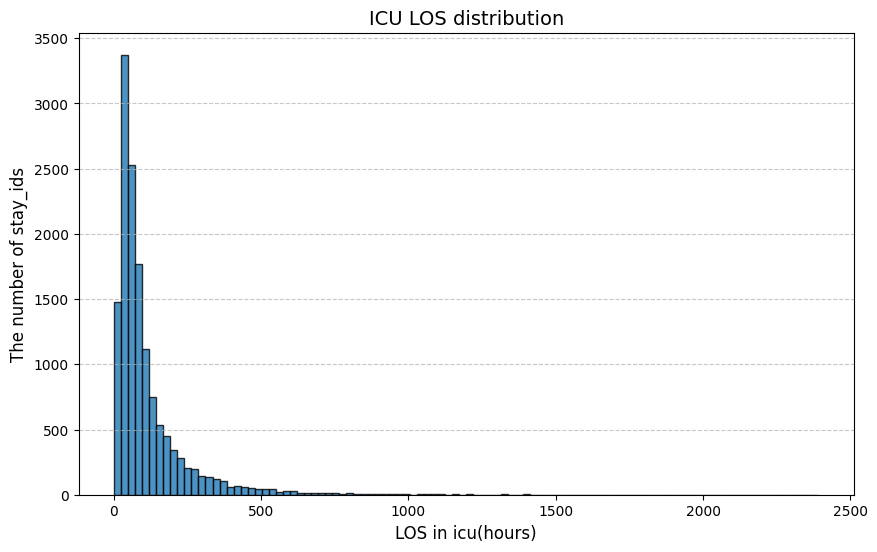

In [133]:
plt.figure(figsize=(10, 6))
plt.hist(updated_df_icustays['los_hours'], bins=100, edgecolor='black', alpha=0.8)
plt.xlabel('LOS in icu(hours)', fontsize=12)
plt.ylabel('The number of stay_ids', fontsize=12)
plt.title('ICU LOS distribution', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [134]:
print("상위 90%: ", np.percentile(updated_df_icustays['los_hours'], 90))
print("상위 95%: ", np.percentile(updated_df_icustays['los_hours'], 95))
print("상위 99%: ", np.percentile(updated_df_icustays['los_hours'], 99))

상위 90%:  253.97847222222222
상위 95%:  362.7211805555556
상위 99%:  695.5868888888888


In [126]:
# 각 환자마다 ICU intime부터 48시간을 1시간 단위로 쪼개어서 hour slot을 생성함
def create_hr_timeslots(icustays_df): 
    time_slots_list = []

    for idx, row in icustays_df.iterrows(): 
        subject_id = row['subject_id']
        hadm_id = row['hadm_id']
        stay_id = row['stay_id']
        intime = row['intime']
        
        for hour_slot in range(24): # 24h
            slot_start = intime + pd.Timedelta(hours=hour_slot)
            time_slots_list.append({
                'subject_id': subject_id,
                'hadm_id': hadm_id,
                'stay_id': stay_id,
                'hour_slot': hour_slot,
                'slot_start': slot_start
            })
    
    time_slots_df = pd.DataFrame(time_slots_list)
    time_slots_df['stay_id'] = time_slots_df['stay_id'].astype('int32')
    time_slots_df['slot_end'] = time_slots_df['slot_start'] + pd.Timedelta(hours=1)

    return time_slots_df

time_slots_df = create_hr_timeslots(key_id_icu)

In [128]:
time_slots_df

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05
...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00


## 4.1 Procedure events

In [137]:
gc.collect()

0

In [138]:
proc_itemid = [225402]

In [139]:
def resampling_procedure_24hr(procedureevents, time_slots_df):

    """
    Procedure event를 proc_itemid를 한정하여 resampling함.
    이때 procedure이 시행되었는지 여부를 0, 1로 라벨링함.
    """

    # 분석에 사용할 itemid만 추출함.
    procedureevents = procedureevents[procedureevents['itemid'].isin(proc_itemid)]

    procedureevents = procedureevents.drop(columns=['valueuom', 'patientweight'])
    procedureevents = procedureevents.sort_values(by=['stay_id', 'itemid', 'starttime']).reset_index(drop=True)

    binary_results = []

    # Binary 처리
    for idx, row in tqdm(procedureevents.iterrows(), total=len(procedureevents), desc="Processing procedureevents"):
        subject = row['subject_id']
        hadm = row['hadm_id']
        stay = row['stay_id']
        start_time = row['starttime']
        end_time = row['endtime']
        itemid = row['itemid']

        patient_slots = time_slots_df[time_slots_df['stay_id'] == stay].copy()

        overlapping = patient_slots[
            (patient_slots['slot_start'] <= end_time) &
            (patient_slots['slot_end'] > start_time)]
        
        if overlapping.empty:
            continue

        for idx, slotrow in overlapping.iterrows(): 
            binary_results.append({
                'subject_id': subject,
                'hadm_id': hadm,
                'stay_id': stay,
                'itemid': itemid,
                'hour_slot': slotrow['hour_slot'],
                'slot_start': slotrow['slot_start'],
                'procedure_flag': 1
            })

    binary_results = pd.DataFrame(binary_results).drop_duplicates()
    expanded_results = []

    for itemid in tqdm(proc_itemid, total = len(proc_itemid), desc = "Processing procedureevents"):
        item_slots = time_slots_df.copy()
        item_slots['itemid'] = itemid
        item_slots['procedure_flag'] = 0

        item_data = binary_results[binary_results['itemid']==itemid]
        
        if not item_data.empty:
            item_slots = pd.merge(item_slots, item_data[['stay_id', 'hour_slot', 'procedure_flag']], how='left', on=['stay_id', 'hour_slot'])
            item_slots['procedure_flag'] = item_slots['procedure_flag_y'].fillna(item_slots['procedure_flag_x']).astype(int)
            item_slots = item_slots.drop(columns=['procedure_flag_x', 'procedure_flag_y'])
        expanded_results.append(item_slots)

    processed_df = pd.concat(expanded_results, ignore_index=True)
    # processed_df = processed_df.drop_duplicates(subset= ['stay_id', 'slot_start'])

    return processed_df

In [140]:
sequential_df_proc = resampling_procedure_24hr(df_proc, time_slots_df)
sequential_df_proc

Processing procedureevents: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,procedure_flag
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,225402,0
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,225402,0
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,225402,1
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,225402,1
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,225402,0
...,...,...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,225402,0
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,225402,0
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,225402,0
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,225402,0


In [181]:
sequential_df_proc[sequential_df_proc['stay_id']==37510196]

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,procedure_flag
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,225402,0
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,225402,0
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,225402,1
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,225402,1
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,225402,0
5,10001884,26184834.0,37510196,5,2131-01-11 09:20:05,2131-01-11 10:20:05,225402,0
6,10001884,26184834.0,37510196,6,2131-01-11 10:20:05,2131-01-11 11:20:05,225402,0
7,10001884,26184834.0,37510196,7,2131-01-11 11:20:05,2131-01-11 12:20:05,225402,0
8,10001884,26184834.0,37510196,8,2131-01-11 12:20:05,2131-01-11 13:20:05,225402,0
9,10001884,26184834.0,37510196,9,2131-01-11 13:20:05,2131-01-11 14:20:05,225402,0


In [141]:
sequential_df_proc.to_feather(root_dir + '/processed/sequential_df_proc.ftr')

## 4.2 Medication(Inputevents)

In [142]:
med_itemid = [221794, 229639, 221906, 221662, 221653, 221749, 221986, 222051, 222056, 225168, 225974, 229709, 220862] # Albumin은 일전에 220864를 단위 변환해서 없애고 220862로 통일하였음.

In [143]:
# inputevents resampling
def resampling_input_24hr(inputevents, time_slots_df): 
    
    """
    input event를 proc_itemid를 한정하여 resampling함.
    투여량을 시간에 비례하여 분할하여 같은 itemid끼리는 합산하여 시간당 투여량을 계산함.
    """

    inputevents = inputevents[inputevents['itemid'].isin(med_itemid)]

    inputevents = inputevents.drop(columns=['rate', 'rateuom', 'patientweight'])
    inputevents = inputevents.sort_values(by=['stay_id', 'itemid', 'starttime']).reset_index(drop=True)

    med_results = []
    expanded_results = []

    for itemid in tqdm(med_itemid, total = len(med_itemid), desc="Processing inputevents"): 
        item_slots = time_slots_df.copy()
        item_slots['itemid'] = itemid
        item_slots['input_amount'] = 0.0

        item_data = inputevents[inputevents['itemid'] == itemid]

        for idx, row in item_data.iterrows():
            subject    = row['subject_id']
            hadm    = row['hadm_id']
            stay    = row['stay_id']
            start_time = row['starttime']
            end_time = row['endtime']    
            amount  = row['amount']

            patient_slots = time_slots_df[time_slots_df['stay_id']==stay].copy()

            overlapping = patient_slots[(patient_slots['slot_start'] <= end_time) & 
                                        (patient_slots['slot_end'] > start_time)]
            
            if overlapping.empty:
                continue
            
            total_hours = (end_time - start_time).total_seconds() / 3600.0
            if total_hours <= 0: 
                continue

            for idx, slotrow in overlapping.iterrows(): 
                slot_start = slotrow['slot_start']
                slot_end = slotrow['slot_end']

                overlap_start = max(start_time, slot_start)
                overlap_end = min(end_time, slot_end)

                hours_in_slot = (overlap_end - overlap_start).total_seconds() / 3600.0
                if hours_in_slot < 0: 
                    hours_in_slot = 0

                amount_per_slot = amount * (hours_in_slot / total_hours)

                existing = next(
                    (
                        result for result in med_results
                        if result['stay_id'] == stay
                        and result['itemid'] == itemid
                        and result['hour_slot'] == slotrow['hour_slot']  
                    ),
                    None,
                )

                if existing: 
                    existing['input_amount'] += amount_per_slot
                    
                else: 
                    med_results.append({
                        'subject_id': subject,
                        'hadm_id': hadm,
                        'stay_id': stay,
                        'itemid': itemid,
                        'hour_slot': slotrow['hour_slot'],
                        'slot_start': slotrow['slot_start'],
                        'input_amount': amount_per_slot
                    })

        item_data_df = pd.DataFrame(med_results)
        item_data_df = item_data_df[item_data_df['itemid'] == itemid]

        if not item_data_df.empty: 
            item_slots = pd.merge(item_slots, item_data_df[['stay_id', 'hour_slot', 'input_amount']], how='left', on = ['stay_id', 'hour_slot'])
            item_slots['input_amount'] = item_slots['input_amount_y'].fillna(item_slots['input_amount_x'])
            item_slots = item_slots.drop(columns=['input_amount_x', 'input_amount_y'])

        expanded_results.append(item_slots)

    processed_df = pd.concat(expanded_results, ignore_index=True)
    
    return processed_df

In [144]:
sequential_df_med = resampling_input_24hr(df_input, time_slots_df)
sequential_df_med

Processing inputevents: 100%|██████████| 13/13 [22:47<00:00, 105.21s/it]


,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,input_amount
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,221794,0.0
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,221794,0.0
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,221794,0.0
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,221794,0.0
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,221794,0.0
...,...,...,...,...,...,...,...,...
4413547,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,220862,0.0
4413548,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,220862,0.0
4413549,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,220862,0.0
4413550,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,220862,0.0


In [180]:
sequential_df_med[sequential_df_med['stay_id']==37510196]

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,input_amount
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,221794,0.0
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,221794,0.0
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,221794,0.0
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,221794,0.0
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,221794,0.0
...,...,...,...,...,...,...,...,...
4074067,10001884,26184834.0,37510196,19,2131-01-11 23:20:05,2131-01-12 00:20:05,220862,0.0
4074068,10001884,26184834.0,37510196,20,2131-01-12 00:20:05,2131-01-12 01:20:05,220862,0.0
4074069,10001884,26184834.0,37510196,21,2131-01-12 01:20:05,2131-01-12 02:20:05,220862,0.0
4074070,10001884,26184834.0,37510196,22,2131-01-12 02:20:05,2131-01-12 03:20:05,220862,0.0


In [145]:
sequential_df_med.to_feather(root_dir + '/processed/sequential_df_med.ftr')

## 4.3 Chart events

In [146]:
# temperature 단위 변환은 완료했으니 하나로 통일
df_chart['itemid'] = df_chart['itemid'].replace({223762:223761})

In [147]:
chart_itemid = [220045, 220179, 220180, 220181, 220277, 220210, 227429, 227446, 225624, 227073, 223761, 220645, 227442]

In [148]:
def resampling_chart_24hr_optimized(chartevents, time_slots_df):

    chartevents = chartevents[chartevents['itemid'].isin(chart_itemid)]
    chartevents = chartevents.sort_values(by=['stay_id', 'itemid', 'charttime']).reset_index(drop=True)

    time_slots_df['slot_end'] = time_slots_df['slot_start'] + pd.Timedelta(hours=1)

    merged = pd.merge_asof(
        chartevents.sort_values('charttime'),
        time_slots_df.sort_values('slot_start'),
        by='stay_id',
        left_on='charttime',
        right_on='slot_start',
        direction='backward'
    )

    merged = merged[(merged['charttime'] >= merged['slot_start']) & (merged['charttime'] < merged['slot_end'])]

    grouped = (
        merged.groupby(['stay_id', 'itemid', 'hour_slot', 'slot_start'])
        .agg(value_sum=('valuenum', 'sum'), value_count=('valuenum', 'count'))
        .reset_index()
    )

    grouped['value'] = grouped['value_sum'] / grouped['value_count']

    all_slots = time_slots_df.copy()
    all_slots = all_slots.assign(key=1)  # Cartesian Product를 위해 key 추가
    items_df = pd.DataFrame({'itemid': chart_itemid, 'key': 1}) 
    full_slots = pd.merge(all_slots, items_df, on='key').drop(columns=['key'])

    final_result = pd.merge(
        full_slots,
        grouped,
        on=['stay_id', 'hour_slot', 'slot_start', 'itemid'],
        how='left'
    )

    final_result = final_result.sort_values(['stay_id', 'itemid', 'slot_start']).reset_index(drop=True)

    return final_result.drop(columns=['value_sum', 'value_count'], errors='ignore')

In [149]:
df_chart[df_chart['itemid'].isin(chart_itemid)]

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom
2,10001884,26184834,37510196,2131-01-18 19:00:00,220045,69,69.00,bpm
3,10001884,26184834,37510196,2131-01-18 19:00:00,220210,17,17.00,insp/min
4,10001884,26184834,37510196,2131-01-18 19:01:00,220179,122,122.00,mmHg
5,10001884,26184834,37510196,2131-01-18 19:01:00,220180,67,67.00,mmHg
6,10001884,26184834,37510196,2131-01-18 19:01:00,220181,84,84.00,mmHg
...,...,...,...,...,...,...,...,...
40339847,19999987,23865745,36195440,2145-11-03 18:30:00,227429,1.13,1.13,ng/mL
40339853,19999987,23865745,36195440,2145-11-04 05:01:00,220645,147,147.00,mEq/L
40339854,19999987,23865745,36195440,2145-11-04 05:01:00,225624,22,22.00,mg/dL
40339857,19999987,23865745,36195440,2145-11-04 05:01:00,227073,11,11.00,mEq/L


In [150]:
sequential_df_chart = resampling_chart_24hr_optimized(df_chart, time_slots_df)

In [151]:
sequential_df_chart

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,value
0,12207593,22795209.0,30000646,0,2194-04-29 01:39:22,2194-04-29 02:39:22,220045,101.000000
1,12207593,22795209.0,30000646,1,2194-04-29 02:39:22,2194-04-29 03:39:22,220045,97.000000
2,12207593,22795209.0,30000646,2,2194-04-29 03:39:22,2194-04-29 04:39:22,220045,93.000000
3,12207593,22795209.0,30000646,3,2194-04-29 04:39:22,2194-04-29 05:39:22,220045,87.000000
4,12207593,22795209.0,30000646,4,2194-04-29 05:39:22,2194-04-29 06:39:22,220045,90.454545
...,...,...,...,...,...,...,...,...
4413547,19046950,24352151.0,39998622,19,2135-02-12 13:13:55,2135-02-12 14:13:55,227446,NaN
4413548,19046950,24352151.0,39998622,20,2135-02-12 14:13:55,2135-02-12 15:13:55,227446,NaN
4413549,19046950,24352151.0,39998622,21,2135-02-12 15:13:55,2135-02-12 16:13:55,227446,NaN
4413550,19046950,24352151.0,39998622,22,2135-02-12 16:13:55,2135-02-12 17:13:55,227446,NaN


In [152]:
sequential_df_chart.to_feather(root_dir + '/processed/sequential_df_chart.ftr')

## 4.4 Output events

In [153]:
df_urine = df_urine[df_urine['urine'] > 0]
df_urine = df_urine[['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'urine']]
df_urine = df_urine.sort_values(by=['stay_id', 'starttime']).reset_index(drop=True)

In [154]:
def resampling_output_24hr_optimized(df_urine, time_slots_df):

    merged = pd.merge(
        df_urine,
        time_slots_df,
        on='stay_id',
        how='inner'
    )

    merged['overlap_start'] = merged[['starttime', 'slot_start']].max(axis=1)
    merged['overlap_end'] = merged[['endtime', 'slot_end']].min(axis=1)
    merged['overlap_hours'] = (merged['overlap_end'] - merged['overlap_start']).dt.total_seconds() / 3600.0

    merged = merged[(merged['overlap_hours'] > 0)]

    total_hours = (merged['endtime'] - merged['starttime']).dt.total_seconds() / 3600.0
    merged['urine_output'] = merged['urine'] * (merged['overlap_hours'] / total_hours)

    grouped = merged.groupby(['stay_id', 'hour_slot'], as_index=False)['urine_output'].sum()

    processed_df = pd.merge(
        time_slots_df,
        grouped,
        on=['stay_id', 'hour_slot'],
        how='left'
    )
    processed_df['urine_output'] = processed_df['urine_output'].fillna(0)

    return processed_df

In [155]:
sequential_df_output = resampling_output_24hr_optimized(df_urine, time_slots_df)
sequential_df_output.to_feather(root_dir + '/processed/sequential_df_output.ftr')

In [179]:
sequential_df_output[sequential_df_output['stay_id']==37510196]

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,urine_output
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,0.000000
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,0.000000
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,92.048611
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,215.296022
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,123.782818
5,10001884,26184834.0,37510196,5,2131-01-11 09:20:05,2131-01-11 10:20:05,226.217182
6,10001884,26184834.0,37510196,6,2131-01-11 10:20:05,2131-01-11 11:20:05,93.531073
7,10001884,26184834.0,37510196,7,2131-01-11 11:20:05,2131-01-11 12:20:05,78.382768
8,10001884,26184834.0,37510196,8,2131-01-11 12:20:05,2131-01-11 13:20:05,70.148305
9,10001884,26184834.0,37510196,9,2131-01-11 13:20:05,2131-01-11 14:20:05,56.765537


In [156]:
sequential_df_output

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,urine_output
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,0.000000
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,0.000000
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,92.048611
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,215.296022
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,123.782818
...,...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,1.250000
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,44.250000
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,0.750000
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,59.000000


## 4.5 CXR (Image modality)

In [157]:
# 동일한 time_slot 내 중복 cxr 확인
check_duplicate_cxrtime = df_cxr[['stay_id', 'cxrtime']]
merged = pd.merge(check_duplicate_cxrtime, time_slots_df, on='stay_id', how='inner')

merged = merged[
    (merged['cxrtime'] >= merged['slot_start']) & 
    (merged['cxrtime'] < merged['slot_start'] + pd.Timedelta(hours=1))
]

duplicate_cxr = (merged.groupby(['stay_id', 'hour_slot']).size().reset_index(name='count').query('count > 1'))

In [158]:
# 한 번의 촬영에서 여러 이미지의 촬영을 가진 환자가 많음. -> 과연 어떤 이미지를 고르는 것이 현명할까?
print("동일한 time slot에 촬영 이미지가 2회 이상인 stay_id 수: ", len(duplicate_cxr[duplicate_cxr['count'] >= 2]))
print("동일한 time slot에 촬영 이미지가 3회 이상인 stay_id 수: ", len(duplicate_cxr[duplicate_cxr['count'] >= 3]))

동일한 time slot에 촬영 이미지가 2회 이상인 stay_id 수:  1720
동일한 time slot에 촬영 이미지가 3회 이상인 stay_id 수:  147


In [ ]:
# time slot에 cxr 할당
## 일단 중복될 경우 첫 번째 이미지를 할당하는 것으로, 나머지 이미지는 버리는 것으로 함.
def assign_cxr_to_slots(cxr, time_slots_df): 

    cxr_sorted = cxr.sort_values(by=['stay_id', 'cxrtime'])
    merged = pd.merge(cxr_sorted, time_slots_df, on='stay_id', how='inner')

    merged = merged[
        (merged['cxrtime'] >= merged['slot_start']) & 
        (merged['cxrtime'] < merged['slot_start'] + pd.Timedelta(hours=1))
    ]

    merged = merged.sort_values(by=['stay_id', 'hour_slot', 'cxrtime']).drop_duplicates(subset=['stay_id', 'hour_slot'], keep='last')

    all_slots = time_slots_df.copy()
    all_slots['cxr_flag'] = 0
    all_slots['image_path'] = np.nan

    all_slots = pd.merge(all_slots, merged[['stay_id', 'hour_slot', 'Img_Folder', 'Img_Filename', 'cxrtime', 'Edema']], 
                         on = ['stay_id', 'hour_slot'], how='left'
                         )

    all_slots['cxr_flag'] = all_slots['Img_Folder'].notna().astype(int)
    all_slots['image_path'] = all_slots.apply(lambda row: f"{row['Img_Folder']}/{row['Img_Filename']}" if row['cxr_flag'] == 1 else None, axis=1)

    processed_df = all_slots.drop(columns=['Img_Folder', 'Img_Filename'])

    return processed_df

In [133]:
sequential_df_cxr = assign_cxr_to_slots(df_cxr, time_slots_df)
sequential_df_cxr

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,cxr_flag,image_path,cxrtime,Edema
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,0,None,NaT,NaN
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,0,None,NaT,NaN
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,0,None,NaT,NaN
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,0,None,NaT,NaN
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,0,None,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,0,None,NaT,NaN
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,0,None,NaT,NaN
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,0,None,NaT,NaN
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,0,None,NaT,NaN


In [138]:
sequential_df_cxr.to_feather(root_dir+'/processed/sequential_df_cxr.ftr')

- 전처리 때는 경로만 넣어놓고, 이후 encoder를 통해 바로바로 경로를 통해 이미지를 불러와서 임베딩함.

## 4.6 radiology report(Text modality)

In [162]:
gc.collect()

0

In [168]:
# bioclinicalBERT tokenizer 사용함.
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

c:\Users\gangmin\AppData\Local\miniconda3\envs\clip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [147]:
# report 전처리
rad_report = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic-iv-note-deidentified-free-text-clinical-notes-2.2/note/radiology.parquet")

- radiology report에 결측된 hadm_id 할당, stay_id 열 신설하여 할당
- key_id_static에 있는 환자만 사용할 수 있도록 수정함.

In [148]:
rad_report['charttime'] = pd.to_datetime(rad_report['charttime'])
rad_report = rad_report[['subject_id', 'hadm_id', 'charttime', 'text']]
rad_report = rad_report.rename(columns={'charttime': 'rad_time'})

In [149]:
# static info 외의 report 삭제
subject_ids = key_id_static['subject_id'].unique()
rad_report = rad_report[rad_report['subject_id'].isin(subject_ids)].reset_index(drop=True)

In [151]:
# report hadm 할당 함수
def assign_report_hadm_id(row, df):
    hadm_records = df[df['subject_id'] == row['subject_id']]

    for idx, record in hadm_records.iterrows():
        if record['admittime'] <= row['rad_time'] <= record['dischtime']:
            return record['hadm_id']
    return None

# report stay_id 할당 함수
def assign_report_stay_id(row, icu_in_out):
    stay_records = icu_in_out[(icu_in_out['subject_id'] == row['subject_id']) & (icu_in_out['hadm_id']==row['hadm_id'])]
    
    for idx, record in stay_records.iterrows():
        if record['intime'] <= row['rad_time'] <= record['outtime']:
            return record['stay_id']
    return None

rad_report['hadm_id'] = rad_report.apply(lambda row: assign_report_hadm_id(row, key_id_static), axis=1)
rad_report['stay_id'] = rad_report.apply(lambda row: assign_report_stay_id(row, key_id_static), axis=1)

In [152]:
print(rad_report['hadm_id'].isnull().sum())
print(rad_report['stay_id'].isnull().sum())

206320
245326


In [ ]:
rad_report = rad_report.dropna(subset=['hadm_id', 'stay_id']).reset_index(drop=True)

In [166]:
rad_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85504 entries, 0 to 85503
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  85504 non-null  int64         
 1   hadm_id     85504 non-null  float64       
 2   rad_time    85504 non-null  datetime64[ns]
 3   text        85504 non-null  object        
 4   stay_id     85504 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.3+ MB


In [167]:
# text는 findings와 impression만 추출해서 사용함.
def extract_findings_and_impressions(text):
    findings = re.search(r"FINDINGS:(.*?)(IMPRESSION:|$)", text, re.DOTALL | re.IGNORECASE)
    impressions = re.search(r"IMPRESSION:(.*)", text, re.DOTALL | re.IGNORECASE)
    
    findings_text = findings.group(1).strip() if findings else ""
    impressions_text = impressions.group(1).strip() if impressions else ""
    
    return findings_text + " " + impressions_text

rad_report['extracted_text'] = rad_report['text'].apply(extract_findings_and_impressions)

In [171]:
rad_report.sort_values(['stay_id', 'rad_time']).reset_index(drop=True)

,subject_id,hadm_id,rad_time,text,stay_id,extracted_text
0,12207593,22795209.0,2194-04-29 06:17:00,PORTABLE CHEST ___ \n\nCOMPARISON: Radiograph...,30000646.0,Cardiac silhouette has increased in size compa...
1,12207593,22795209.0,2194-04-30 08:16:00,INDICATION: ___ man with history of non small...,30000646.0,The cardiac silhouette remains enlarged probab...
2,12207593,22795209.0,2194-05-01 07:14:00,"HISTORY: NSLC, to assess for change.\n\nFINDI...",30000646.0,"In comparison with the study of ___, there is ..."
3,12207593,22795209.0,2194-05-01 13:01:00,BILATERAL UPPER EXTREMITY ULTRASOUND\n\nINDICA...,30000646.0,No evidence of DVT. Thrombosis of the right ...
4,12207593,22795209.0,2194-05-02 10:25:00,INDICATION: ___ man with non-small cell lung ...,30000646.0,As compared to prior chest radiograph from ___...
...,...,...,...,...,...,...
85499,19046950,24352151.0,2135-02-17 14:39:00,INDICATION: Status post hernia repair in the ...,39998622.0,LOWER CHEST: Please see the chest CT report fo...
85500,19046950,24352151.0,2135-02-17 14:39:00,EXAMINATION: CT CHEST W/CONTRAST\n\nINDICATIO...,39998622.0,The imaged portions of the thyroid gland are n...
85501,19046950,24352151.0,2135-02-18 05:22:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,39998622.0,Lung volumes are low and there is increased vo...
85502,19046950,24352151.0,2135-02-19 05:22:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,39998622.0,"As compared to ___ radiograph, bibasilar atel..."


In [ ]:
# def tokenize_and_embed(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

#     with torch.no_grad():
#         outputs = model(**inputs)
    
#     # CLS 토큰만 사용함.
#     cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

#     return cls_embedding

In [ ]:
# rad_report.loc[:, 'tokenized_text'] = rad_report.loc[:, 'extracted_text'].apply(tokenize_and_embed).reset_index(drop=True)
# rad_report = rad_report.sort_values(['stay_id', 'rad_time']).reset_index(drop=True)

- time slot에 rad_report 할당

In [172]:
def assign_reports_to_slots(rad_report, time_slots_df):
    rad_sorted = rad_report.sort_values(by=['stay_id', 'rad_time'])
    merged = pd.merge(rad_sorted, time_slots_df, on='stay_id', how='inner')

    merged = merged[
        (merged['rad_time'] >= merged['slot_start']) & 
        (merged['rad_time'] < merged['slot_end'])
    ]

    # 같은 슬롯 안에 2개 이상의 보고서가 존재할 경우, 
    merged = merged.sort_values(by=['stay_id', 'hour_slot', 'rad_time']).drop_duplicates(subset=['stay_id', 'hour_slot'], keep='last')

    all_slots = time_slots_df.copy()

    processed_df  = pd.merge(all_slots, merged[['stay_id', 'hour_slot', 'extracted_text']], how='left', on=['stay_id', 'hour_slot'])

    return processed_df

In [173]:
sequential_df_reports = assign_reports_to_slots(rad_report, time_slots_df)
sequential_df_reports

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,extracted_text
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,Fluoroscopic images show placement of a tempo...
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,NaN
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,"In comparison with the study of ___, there ha..."
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,NaN
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,NaN
...,...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,NaN
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,NaN
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,NaN
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,NaN


In [174]:
sequential_df_reports.to_feather(root_dir+'/processed/sequential_df_reports.ftr')

# 5. Chartevents Imputatioon

1. 우선적으로 forward fill 시행
2. 만약 가장 앞에 있는 값이 결측치에 해당할 경우, 후미에 있는 값들을 backward filling 진행함.

In [ ]:
gc.collect()

7

In [175]:
def impute_time_series(df, df_ditems, gap_hours=3):

    """
    gap_hours: 임상적으로 의미있는 최대 간격 (여기서는 3시간)
    return: imputed_df (결측 보간 + missing indicator 추가)
    """

    df = df.merge(df_ditems[['itemid','category']].drop_duplicates(), on='itemid', how='left')
    df = df.sort_values(by=['subject_id','hadm_id','stay_id','itemid','slot_start']).reset_index(drop=True)
    
    imputed_list = []
    
    groups = df.groupby(['subject_id','hadm_id','stay_id','itemid'], as_index=False)
    for keys, group in tqdm(groups, total=len(groups), desc="Imputing time series data: "):
        subject_id, hadm_id, stay_id, itemid = keys
        group = group.copy().reset_index(drop=True)

        # # missing indicator
        # group['was_missing'] = group['value'].isna().astype(int)
        
        # [1]: 첫 유효값 이전 구간만 한번에 bbfill
        group = backward_fill_first_nan(group)
        
        # [2]: 특정 category일 때 gap_hours 이하인 값들에 대해서만 선형 보간을 우선 수행
        category = group['category'].iloc[0]
        if category in ['Respiratory']: # 'Labs', 'Routine Vital Signs', 'Respiratory'
            group = linear_interpolate_with_gap_limit(group, gap_hours=gap_hours)

        # [3]: 앞선 선형 보간과 중복되지 않는 구간에 한해서 gap_hours 이하인 값들에 대해 ffill 적용함.
        else: 
            group = forward_fill_with_gap_limit(group, gap_hours=gap_hours)

        imputed_list.append(group)

    imputed_df = pd.concat(imputed_list, ignore_index=True)
    imputed_df = imputed_df.sort_values(by=['subject_id', 'hadm_id', 'stay_id', 'itemid', 'slot_start']).reset_index(drop=True)

    return imputed_df

def backward_fill_first_nan(group): 
    """
    처음으로 등장하는 유효값 이전에 있는 모든 NaN을 첫 유효값으로 채움.
    """
    first_valid_idx = group['value'].first_valid_index()
    if first_valid_idx is not None: 
        first_val = group.loc[first_valid_idx, 'value']
        # first_val로 NaN인 경우 채우기
        group.loc[:first_valid_idx-1, 'value'] = first_val

    return group

def linear_interpolate_with_gap_limit(group, gap_hours): 
    """
    group에서 연속된 구간 사이가 gap_hours 이하일 때만 선형 보간
    gap_hours 초과하면 보간 적용 안하고 NaN 유지함.
    """
    values = group['value'].values
    times = group['slot_start'].values

    notnull_idx = np.where(~pd.isna(values))[0]

    for idx in range(len(notnull_idx) -1): 
        left_idx = notnull_idx[idx]
        right_idx = notnull_idx[idx+1]

        left_time = times[left_idx]
        right_time = times[right_idx]

        time_difference = (right_time - left_time) / np.timedelta64(1, 'h')

        if time_difference <= gap_hours:
            left_value = values[left_idx]
            right_value = values[right_idx]

            for mid_idx in range(left_idx + 1, right_idx): 
                if pd.isna(values[mid_idx]): 
                    tm = times[mid_idx]
                    ratio = (tm - left_time) / (right_time - left_time)
                    values[mid_idx] = left_value + (right_value - left_value) * ratio

    group['value'] = values

    return group

def forward_fill_with_gap_limit(group, gap_hours):
    """
    이전 유효값과 현재 슬롯의 시간 차가 gap_hours 이하일 때만 ffill 적용함.
    """
    values = group['value'].values
    times = group['slot_start'].values

    last_valid_value = np.nan
    last_valid_time = pd.NaT

    for idx in range(len(values)): 
        if not pd.isna(values[idx]):
            last_valid_value = values[idx]
            last_valid_time = times[idx]

        else:
            if pd.notna(last_valid_time):
                time_difference = (times[idx] - last_valid_time) / np.timedelta64(1, 'h')

                if time_difference <= gap_hours:
                    values[idx] = last_valid_value

    group['value'] = values

    return group

In [188]:
labeling = df_cxr[['stay_id', 'cxrtime', 'Edema']]
labeling

,stay_id,cxrtime,Edema
0,37510196.0,2131-01-15 04:45:09.078,0.0
1,37510196.0,2131-01-12 04:56:56.359,1.0
2,37510196.0,2131-01-13 04:49:18.484,1.0
3,37510196.0,2131-01-14 10:34:28.765,-1.0
4,35479615.0,2156-05-18 02:47:37.203,1.0
...,...,...,...
57909,35165301.0,2197-08-07 09:06:37.796,0.0
57910,35165301.0,2197-08-05 09:37:46.343,0.0
57911,32336619.0,2148-11-19 22:47:03.375,0.0
57912,36195440.0,2145-11-04 05:14:48.218,0.0


In [176]:
imputed_chart = impute_time_series(sequential_df_chart, df_ditems, gap_hours=3)
imputed_chart

Imputing time series data: 100%|██████████| 183898/183898 [02:21<00:00, 1295.26it/s]


,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,value,category
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,220045,49.000000,Routine Vital Signs
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,220045,72.000000,Routine Vital Signs
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,220045,70.666667,Routine Vital Signs
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,220045,71.000000,Routine Vital Signs
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,220045,71.000000,Routine Vital Signs
...,...,...,...,...,...,...,...,...,...
4413547,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,227446,NaN,Labs
4413548,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,227446,NaN,Labs
4413549,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,227446,NaN,Labs
4413550,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,227446,NaN,Labs


In [177]:
imputed_chart.to_feather(root_dir + '/processed/imputed_df_chart.ftr')

In [216]:
df_pivot_chart = imputed_chart.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='itemid',                
    values='value',
).reset_index()

df_pivot_chart

itemid,stay_id,hour_slot,220045,220179,220180,220181,220210,220277,220645,223761,225624,227073,227429,227442,227446
0,30000646,0,101.000000,109.000000,65.500000,75.000000,30.500000,97.500000,138.0,37.111111,12.0,12.0,0.02,3.5,NaN
1,30000646,1,97.000000,97.000000,58.000000,67.000000,19.000000,94.000000,138.0,37.111111,12.0,12.0,0.02,3.5,NaN
2,30000646,2,93.000000,98.000000,57.000000,67.000000,18.000000,98.000000,138.0,37.111111,12.0,12.0,0.02,3.5,NaN
3,30000646,3,87.000000,98.000000,66.000000,73.000000,24.000000,98.000000,138.0,37.111111,12.0,12.0,0.02,3.5,NaN
4,30000646,4,90.454545,96.714286,61.428571,69.142857,30.454545,94.363636,141.0,39.111111,12.0,12.0,0.02,3.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332941,39998622,19,121.000000,NaN,NaN,NaN,5.000000,95.000000,NaN,37.500000,NaN,NaN,NaN,NaN,NaN
332942,39998622,20,124.000000,NaN,NaN,NaN,14.000000,94.000000,NaN,37.500000,NaN,NaN,NaN,NaN,NaN
332943,39998622,21,122.000000,NaN,NaN,NaN,25.000000,94.000000,NaN,37.666667,NaN,NaN,NaN,NaN,NaN
332944,39998622,22,118.000000,NaN,NaN,NaN,28.000000,96.000000,NaN,37.666667,NaN,NaN,NaN,NaN,NaN


In [215]:
df_pivot_input = sequential_df_med.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='itemid',                
    values='input_amount',
).reset_index()

df_pivot_input

itemid,stay_id,hour_slot,220862,221653,221662,221749,221794,221906,221986,222051,222056,225168,225974,229639,229709
0,30000646,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000646,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30000646,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30000646,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30000646,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339499,39998622,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339500,39998622,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339501,39998622,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339502,39998622,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
df_pivot_proc = sequential_df_proc.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='itemid',                
    values='procedure_flag',
).reset_index()

df_pivot_proc

itemid,stay_id,hour_slot,225402
0,30000646,0,1.0
1,30000646,1,0.0
2,30000646,2,0.0
3,30000646,3,0.0
4,30000646,4,1.0
...,...,...,...
339499,39998622,19,0.0
339500,39998622,20,0.0
339501,39998622,21,0.0
339502,39998622,22,0.0


In [ ]:
sequential_df_output.loc[:, 'urine'] = 'urine'

df_pivot_output = sequential_df_output.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='urine',                
    values='urine_output',
).reset_index()

df_pivot_output

urine,stay_id,hour_slot,urine
0,30000646,0,0.000000
1,30000646,1,0.000000
2,30000646,2,0.000000
3,30000646,3,529.277778
4,30000646,4,170.722222
...,...,...,...
339499,39998622,19,31.716102
339500,39998622,20,20.000000
339501,39998622,21,23.283898
339502,39998622,22,36.094633


In [227]:
sequential_df_cxr

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,cxr_flag,image_path
0,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,0,None
1,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,0,None
2,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,0,None
3,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,0,None
4,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,0,None
...,...,...,...,...,...,...,...,...
339499,19999987,23865745.0,36195440,19,2145-11-03 17:59:00,2145-11-03 18:59:00,0,None
339500,19999987,23865745.0,36195440,20,2145-11-03 18:59:00,2145-11-03 19:59:00,0,None
339501,19999987,23865745.0,36195440,21,2145-11-03 19:59:00,2145-11-03 20:59:00,0,None
339502,19999987,23865745.0,36195440,22,2145-11-03 20:59:00,2145-11-03 21:59:00,0,None


---

In [ ]:
df_pivot_cxr = sequential_df_cxr.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='cxr_flag',                
    values='image_path',
).reset_index()

df_pivot_cxr

In [ ]:
df_pivot_report = sequential_df_reports.pivot_table(
    index=['stay_id', 'hour_slot'],   
    columns='report_flag',                
    values='tokenized_text',
).reset_index()

df_pivot_report

---

In [ ]:
# Anion gap
df_chart[(df_chart['stay_id']==37510196) & (df_chart['itemid']==220277)]

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom
7,10001884,26184834,37510196,2131-01-18 19:04:00,220277,100,100.0,%
14,10001884,26184834,37510196,2131-01-18 20:00:00,220277,100,100.0,%
52,10001884,26184834,37510196,2131-01-18 21:00:00,220277,92,92.0,%
60,10001884,26184834,37510196,2131-01-18 22:00:00,220277,99,99.0,%
70,10001884,26184834,37510196,2131-01-18 23:14:00,220277,98,98.0,%
...,...,...,...,...,...,...,...,...
4111,10001884,26184834,37510196,2131-01-15 23:00:00,220277,98,98.0,%
4134,10001884,26184834,37510196,2131-01-16 03:00:00,220277,100,100.0,%
4158,10001884,26184834,37510196,2131-01-16 20:00:00,220277,100,100.0,%
4233,10001884,26184834,37510196,2131-01-11 06:00:00,220277,100,100.0,%


In [380]:
sequential_df_chart[(sequential_df_chart['stay_id']==37510196) & (sequential_df_chart['itemid']==227073)]

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,value
3298680,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,227073,NaN
3298681,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,227073,NaN
3298682,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,227073,11.0
3298683,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,227073,NaN
3298684,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,227073,NaN
3298685,10001884,26184834.0,37510196,5,2131-01-11 09:20:05,2131-01-11 10:20:05,227073,NaN
3298686,10001884,26184834.0,37510196,6,2131-01-11 10:20:05,2131-01-11 11:20:05,227073,NaN
3298687,10001884,26184834.0,37510196,7,2131-01-11 11:20:05,2131-01-11 12:20:05,227073,NaN
3298688,10001884,26184834.0,37510196,8,2131-01-11 12:20:05,2131-01-11 13:20:05,227073,NaN
3298689,10001884,26184834.0,37510196,9,2131-01-11 13:20:05,2131-01-11 14:20:05,227073,NaN


In [379]:
imputed_chart[(imputed_chart['stay_id']==37510196) & (imputed_chart['itemid']==227073)]

,subject_id,hadm_id,stay_id,hour_slot,slot_start,slot_end,itemid,value,category
216,10001884,26184834.0,37510196,0,2131-01-11 04:20:05,2131-01-11 05:20:05,227073,11.0,Labs
217,10001884,26184834.0,37510196,1,2131-01-11 05:20:05,2131-01-11 06:20:05,227073,11.0,Labs
218,10001884,26184834.0,37510196,2,2131-01-11 06:20:05,2131-01-11 07:20:05,227073,11.0,Labs
219,10001884,26184834.0,37510196,3,2131-01-11 07:20:05,2131-01-11 08:20:05,227073,11.0,Labs
220,10001884,26184834.0,37510196,4,2131-01-11 08:20:05,2131-01-11 09:20:05,227073,11.0,Labs
221,10001884,26184834.0,37510196,5,2131-01-11 09:20:05,2131-01-11 10:20:05,227073,11.0,Labs
222,10001884,26184834.0,37510196,6,2131-01-11 10:20:05,2131-01-11 11:20:05,227073,NaN,Labs
223,10001884,26184834.0,37510196,7,2131-01-11 11:20:05,2131-01-11 12:20:05,227073,NaN,Labs
224,10001884,26184834.0,37510196,8,2131-01-11 12:20:05,2131-01-11 13:20:05,227073,NaN,Labs
225,10001884,26184834.0,37510196,9,2131-01-11 13:20:05,2131-01-11 14:20:05,227073,NaN,Labs


In [ ]:
sequential_df_chart[(sequential_df_chart['stay_id']==37510196) & (sequential_df_chart['itemid']==220210)]

In [ ]:
imputed_chart[(imputed_chart['stay_id']==37510196) & (imputed_chart['itemid']==220210)]